# Détectez les Bad Buzz grâce au Deep Learning

## Importation des bibliothèques nécessaires

In [1]:
# Librairies de manipulation de données et de visualisation
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Librairie pour la classification de texte
import fasttext

# Librairies de traitement de texte
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import ftfy
import contractions
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Librairies d'apprentissage automatique
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report, roc_curve, auc
from sklearn.dummy import DummyClassifier


# Librairies spécifiques à MLFlow
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.keras

# Librairies spécifiques à TensorFlow
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, Input,GRU
from tensorflow.keras.metrics import AUC
from transformers import TFBertModel, BertTokenizer
import tensorflow_hub as hub
from tensorflow.keras.layers import Lambda, SimpleRNN, LSTM, Bidirectional
from keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.callbacks import EarlyStopping

# Librairies systéme
import os
import joblib
import numpy as np
import threading
import time
import psutil

# Librairie pour l'optimisation de modèles Keras
import kerastuner as kt

# Librairie pour le traitement des émojis
import emoji

2024-03-14 15:22:47.855357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 15:22:47.855403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 15:22:47.856510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 15:22:47.862858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 15:22:48.664179: W tensorflow/compiler/tf2

In [2]:
cache_data = True

## Chargement des données

In [3]:
if not os.path.exists("data/clean/data.csv"):
    cache_data = False
else :
    cache_data = True
display(cache_data) 

False

In [4]:
if cache_data == False:
    # Chargement des données brutes
    data = pd.read_csv("data/RAW/training.1600000.processed.noemoticon.csv",names=["target", "id", "date", "query", "user", "text"], encoding='ISO-8859-1')
    
    # Correction de l'encodage du texte
    def fix_encoding(text):
        return ftfy.fix_text(text)

    data['text'] = data['text'].apply(fix_encoding)
    display(data.info())
    display(data.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   query   1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


None

target            id                          date     query  \
count   1.600000e+06  1.600000e+06                       1600000   1600000   
unique           NaN           NaN                        774363         1   
top              NaN           NaN  Mon Jun 15 12:53:14 PDT 2009  NO_QUERY   
freq             NaN           NaN                            20   1600000   
mean    2.000000e+00  1.998818e+09                           NaN       NaN   
std     2.000001e+00  1.935761e+08                           NaN       NaN   
min     0.000000e+00  1.467810e+09                           NaN       NaN   
25%     0.000000e+00  1.956916e+09                           NaN       NaN   
50%     2.000000e+00  2.002102e+09                           NaN       NaN   
75%     4.000000e+00  2.177059e+09                           NaN       NaN   
max     4.000000e+00  2.329206e+09                           NaN       NaN   

            user                       text  
count    1600000                    1600000  
unique    659775                    1581466  
top     lost_dog  isPlayer Has Died! Sorry   
freq         549                        210  
mean         NaN                        NaN  
std          NaN                        NaN  
min          NaN                        NaN  
25%          NaN                        NaN  
50%          NaN                        NaN  
75%          NaN                        NaN  
max          NaN                        NaN

## Prétraitement des données

### Suppression des tweets en doublons

In [5]:
if cache_data == False:
    # Suppression des tweets en doublons
    data = data.drop_duplicates(subset=['id'])
    data = data.drop_duplicates(subset=['date', 'user','text'])

### Suppression des colonnes inutiles

In [6]:
if cache_data == False:
    data = data.drop(columns=['id','query'])
    display(data)

target                          date             user  \
0             0  Mon Apr 06 22:19:45 PDT 2009  _TheSpecialOne_   
1             0  Mon Apr 06 22:19:49 PDT 2009    scotthamilton   
2             0  Mon Apr 06 22:19:53 PDT 2009         mattycus   
3             0  Mon Apr 06 22:19:57 PDT 2009          ElleCTF   
4             0  Mon Apr 06 22:19:57 PDT 2009           Karoli   
...         ...                           ...              ...   
1599995       4  Tue Jun 16 08:40:49 PDT 2009  AmandaMarie1028   
1599996       4  Tue Jun 16 08:40:49 PDT 2009      TheWDBoards   
1599997       4  Tue Jun 16 08:40:49 PDT 2009           bpbabe   
1599998       4  Tue Jun 16 08:40:49 PDT 2009     tinydiamondz   
1599999       4  Tue Jun 16 08:40:50 PDT 2009   RyanTrevMorris   

                                                      text  
0        @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1        is upset that he can't update his Facebook by ...  
2        @Kenichan I dived many times for the ball. Man...  
3          my whole body feels itchy and like its on fire   
4        @nationwideclass no, it's not behaving at all....  
...                                                    ...  
1599995  Just woke up. Having no school is the best fee...  
1599996  TheWDB.com - Very cool to hear old Walt interv...  
1599997  Are you ready for your MoJo Makeover? Ask me f...  
1599998  Happy 38th Birthday to my boo of alll time!!! ...  
1599999  happy #charitytuesday @theNSPCC @SparksCharity...  

[1598127 rows x 4 columns]

### Analyse primaire des données

In [7]:
if cache_data == False:
    display(data['target'].value_counts())

target
0    799915
4    798212
Name: count, dtype: int64

- 0 = negative
- 4 = positive

#### Remplacement des étiquettes : 0 = négatif, 4 = positif

- 0 = négatif
- 1 = positif

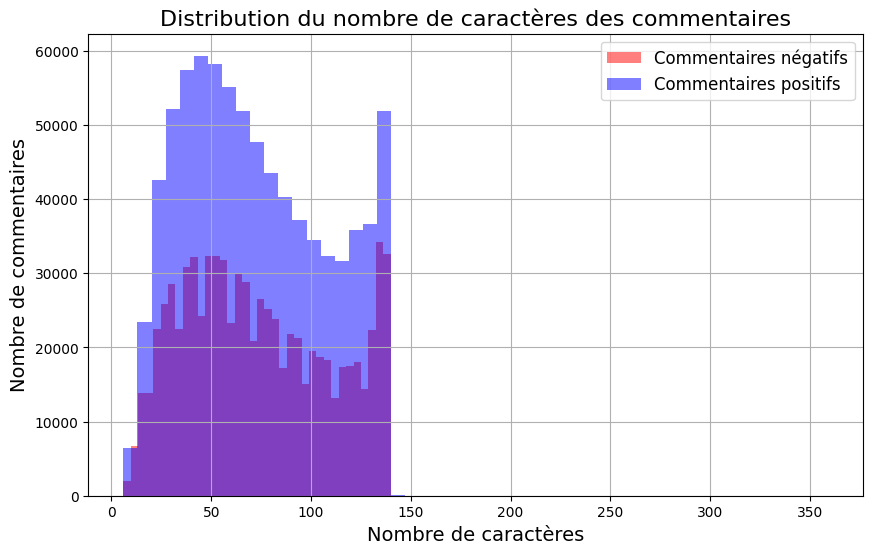

In [8]:
if cache_data == False:
    data['target'] = data['target'].replace(4, 1)
    data_negatif = data[data['target'] == 0]
    data_positif = data[data['target'] == 1]
    longueur_negatif = data_negatif['text'].apply(len)
    longueur_positif = data_positif['text'].apply(len)
    
    # Visualisation de la distribution de la longueur des tweets
    plt.figure(figsize=(10, 6))

    plt.hist(longueur_negatif, bins=50, alpha=0.5, color='red', label='Commentaires négatifs')
    plt.hist(longueur_positif, bins=50, alpha=0.5, color='blue', label='Commentaires positifs')

    plt.title('Distribution du nombre de caractères des commentaires', fontsize=16)
    plt.xlabel('Nombre de caractères', fontsize=14)
    plt.ylabel('Nombre de commentaires', fontsize=14)
    plt.legend(fontsize=12)

    plt.grid(True)

    plt.show()

### Détection de la langue des tweets

In [9]:
if cache_data == False:
    # model = fasttext.load_model('lid.176.bin')
    model = fasttext.load_model('lid.176.ftz')

    def detect_languages_fasttext(text_series):
        """
        Détecte la langue des textes à l'aide du modèle FastText.

        :param text_series: Une série de textes à analyser.
        :type text_series: pandas.Series
        :return: Une liste des langues détectées pour chaque texte.
        :rtype: list
        """
        # Nettoyage des textes en remplaçant les sauts de ligne par un espace
        cleaned_text_series = text_series.astype(str).str.replace('\n', ' ', regex=False)
        
        # Prédictions des langues avec le modèle FastText
        predictions = model.predict(cleaned_text_series.tolist(), k=1)
        
        # Extraction des langues détectées à partir des prédictions
        languages = []
        for prediction in predictions[0]:
            if prediction:
                language = prediction[0].split('__label__')[1]
            else:
                language = 'unknown'
            languages.append(language)
        return languages

    data['lang'] = detect_languages_fasttext(data['text'])
    display(data['lang'].value_counts())

lang
en     1561682
de        7401
es        6499
ja        3568
fr        2872
        ...   
vec          1
wa           1
sd           1
bcl          1
new          1
Name: count, Length: 129, dtype: int64

### Nettoyage et prétraitement du texte

In [10]:
if cache_data == False:
    nltk.download('all')
    nltk.download('stopwords')
    nltk.download('wordnet')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/nlombard/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/nlombard/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/nlombard/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/nlombard/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/nlombard/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading pa

In [11]:
if cache_data == False:
    def process_text_vectorized(text_series, lng_series):
        """
        Prétraitement vectorisé du texte, comprenant la suppression des mentions, hashtags, URL et de la ponctuation,
        la conversion en minuscules, conversion des emoji, la suppression des mots vides (stop words) et la lemmatisation.

        :param text_series: Une série de textes à traiter.
        :type text_series: pandas.Series
        :param lng_series: Une série de langues correspondant à chaque texte.
        :type lng_series: pandas.Series
        :return: Une série de textes traités.
        :rtype: pandas.Series
        """
        text_series = text_series.apply(contractions.fix)
        
        # Suppression des mentions, hashtags, URL et de la ponctuation, conversion en minuscules, conversion des emoji
        text_series = text_series.str.replace(r'@\w+ ?', '', regex=True)\
                            .str.replace(r'#\w+ ?', '', regex=True)\
                            .str.replace(r'http\S+ ?', '', regex=True)\
                            .apply(emoji.demojize, delimiters=("", ""))\
                            .str.replace('[{}]'.format(string.punctuation), '', regex=True)\
                            .str.lower()\
                            .str.replace(r'[^\w\s]', '', regex=True)
        
        # Dictionnaire des langues et de leurs mots vides associés
        languages = {
            "da": 'danish', "nl": 'dutch', "en": 'english', "fi": 'finnish', "fr": 'french',
            "de": 'german', "el": 'greek', "it": 'italian', "no": 'norwegian', "pt": 'portuguese',
            "ru": 'russian', "sl": 'slovene', "es": 'spanish', "sv": 'swedish', "tr": 'turkish'
        }

        negative_words_map = {
            "en": {"not", "never", "nothing", "no", "nor", "however", "yet", "nevertheless", "nonetheless", "but"},
            "fr": {"pas", "jamais", "rien", "aucun", "ni","cependant",'pourtant','néanmoins','toutefois','or','mais'},
            "de": {"nicht", "nie", "nichts", "kein", "noch", "jedoch", "dennoch", "nichtsdestotrotz", "gleichwohl", "aber"},
            "es": {"no", "jamás", "nada", "ningún", "ni", "sin embargo", "no obstante", "sin embargo", "no obstante", "sin embargo","pero"},
            "it": {"non", "mai", "nulla", "nessun", "né", "tuttavia", "però", "nonostante ciò", "tuttavia", "però","ma"},
            "pt": {"não", "nunca", "nada", "nenhum", "nem", "no entanto", "entretanto", "todavia", "no entanto", "porém","mas"},
            "da": {"ikke", "aldrig", "ingenting", "ingen", "hverken", "dog", "alligevel", "ikke desto mindre", "imidlertid", "men"},
            "nl": {"niet", "nooit", "niets", "geen", "noch", "echter", "desalniettemin", "niettemin", "evenwel", "maar"},
            "fi": {"ei", "koskaan", "mitään", "ei mitään", "ei", "kuitenkin", "kuitenkin", "kuitenkin", "kuitenkin", "kuitenkin","mutta"},
            "el": {"όχι", "ποτέ", "τίποτα", "κανένας", "ούτε", "όμως", "παρ' όλα αυτά", "παρ' όλο αυτό", "παρ' όλο αυτό", "αλλά"},
            "no": {"ikke", "aldri", "ingenting", "ingen", "heller ikke", "likevel", "likevel", "likevel", "likevel", "likevel","men"},
            "ru": {"не", "никогда", "ничего", "нет", "ни", "однако", "тем не менее", "однако", "всё же", "но"},
            "sl": {"ne", "nikoli", "nič", "noben", "niti", "vendar", "vendar", "vendar", "vendar", "vendar","ampak"},
            "sv": {"inte", "aldrig", "ingenting", "ingen", "varken", "dock", "ändå", "trots detta", "dock", "men"},
            "tr": {"değil", "asla", "hiçbir şey", "hiçbir", "ne", "ancak", "yine de", "yine de", "yine de", "ama"}
        }

        # Création d'un dictionnaire des mots vides pour chaque langue
        stopwords_dict = {lng: set(stopwords.words(lang)) for lng, lang in languages.items()}
        
        lemmatizer = WordNetLemmatizer()

        def remove_stopwords_and_lemmatize(text, stopwords, negative_words):
            return ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords or word in negative_words])

        # Parcours des langues et traitement des textes
        for lng in languages.keys():
            if lng in lng_series.unique():
                negative_words = negative_words_map.get(lng, set())
                stop_words = stopwords_dict[lng]
                
                # Masque pour les textes dans la langue courante
                mask = lng_series == lng
                # Application de la fonction `remove_stopwords_and_lemmatize` aux textes de cette langue
                text_series.loc[mask] = text_series[mask].apply(remove_stopwords_and_lemmatize, args=(stop_words, negative_words))
    
        data['formatted_text'] = process_text_vectorized(data['text'], data['lang'])

    data = pd.DataFrame(data)
    pd.set_option('display.max_colwidth', None)
    display(data.head(150))
    pd.reset_option('display.max_colwidth')

target                          date             user  \
0         0  Mon Apr 06 22:19:45 PDT 2009  _TheSpecialOne_   
1         0  Mon Apr 06 22:19:49 PDT 2009    scotthamilton   
2         0  Mon Apr 06 22:19:53 PDT 2009         mattycus   
3         0  Mon Apr 06 22:19:57 PDT 2009          ElleCTF   
4         0  Mon Apr 06 22:19:57 PDT 2009           Karoli   
..      ...                           ...              ...   
145       0  Mon Apr 06 22:28:24 PDT 2009     treehugger25   
146       0  Mon Apr 06 22:28:26 PDT 2009        chatpataa   
147       0  Mon Apr 06 22:28:26 PDT 2009    ThisStoutjunt   
148       0  Mon Apr 06 22:28:33 PDT 2009         sew_cute   
149       0  Mon Apr 06 22:28:32 PDT 2009         Twokids1   

                                                                                                                                          text  \
0                          @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D   
1                              is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!   
2                                                    @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds   
3                                                                                              my whole body feels itchy and like its on fire    
4                              @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.    
..                                                                                                                                         ...   
145          @twista202 I still haven't read the 9th&10th Princess diaries  Saving Francesca made me cry at the end. Hmm those are easy books.   
146                                                                                                                     my nokia 1110 died..     
147                                                  My mom might have breast cancer won't find out anything for. Like a week I'm so worried!    
148                                                                                          Going to sleep. Hoping tomorrow is a better day.    
149  @rumblepurr lol.. wish they understood daylight savings has ended though and breakfast is an hour later  They keep waking the kids up too   

    lang  \
0     en   
1     en   
2     en   
3     en   
4     en   
..   ...   
145   en   
146   en   
147   en   
148   en   
149   en   

                                                                            formatted_text  
0                                             awww bummer shoulda got david carr third day  
1             upset cannot update facebook texting might cry result school today also blah  
2                                       dived many time ball managed save 50 rest go bound  
3                                                          whole body feel itchy like fire  
4                                                           no not behaving mad cannot see  
..                                                                                     ...  
145      still not read 9th10th princess diary saving francesca made cry end hmm easy book  
146                                                                        nokia 1110 died  
147                            mom might breast cancer not find anything like week worried  
148                                                 going sleep hoping tomorrow better day  
149  lol wish understood daylight saving ended though breakfast hour later keep waking kid  

[150 rows x 6 columns]

### Supprimer les text vide

In [12]:
if cache_data == False:
    display(data.shape[0])
    data = data[data['formatted_text'].str.strip().str.len() > 0]
    data = data[data['formatted_text'].str.replace(r'\W+', '').str.len() > 0]
    display(data.shape[0])

1598127

1591300

### Supprimer les messages doublons

In [13]:
if cache_data == False:
    display(data.shape[0])
    display(data[data.duplicated(subset=['user', 'formatted_text'], keep=False)].sort_values(by='formatted_text'))
    data = data.drop_duplicates(subset=['user', 'formatted_text'])
    display(data.shape[0])
    display(data[data['user'] == "tweetpet"])

1591300

target                          date          user  \
46515         0  Sat May 02 02:00:30 PDT 2009      tweetpet   
31975         0  Mon Apr 20 02:00:07 PDT 2009      tweetpet   
47299         0  Sat May 02 03:00:16 PDT 2009      tweetpet   
37018         0  Mon Apr 20 08:00:15 PDT 2009      tweetpet   
47280         0  Sat May 02 03:00:08 PDT 2009      tweetpet   
...         ...                           ...           ...   
641426        0  Fri Jun 19 00:45:18 PDT 2009  EmilyxRose92   
424692        0  Sun Jun 07 01:36:00 PDT 2009      Squintox   
424357        0  Sun Jun 07 01:17:13 PDT 2009      Squintox   
1388948       1  Sat Jun 06 03:08:39 PDT 2009   libbyabrego   
1388750       1  Sat Jun 06 03:04:33 PDT 2009   libbyabrego   

                                                      text lang  \
46515                                 @grupozis  Clean Me!   eo   
31975                                @anggiemoy  Clean Me!   id   
47299                                 @anioklin  Clean Me!   eo   
37018                                @anggiemoy  Clean Me!   id   
47280                                @anggiemoy  Clean Me!   id   
...                                                    ...  ...   
641426   @Noifsandsormybs ZOMG I WANT TO SEE THIS NOW! ...   en   
424692   アイシテル第1話 - that was very sad  no mother deserv...   en   
424357   アイシテル第1話 - that was very sad  no mother deserv...   en   
1388948  油貓餅 = I D0N'T KN0W WHAT IT MEAN BUT it L00KS K...   en   
1388750  油貓餅 = I D0N'T KN0W WHAT IT MEANs BUT it L00KS ...   en   

                                           formatted_text  
46515                                            clean me  
31975                                            clean me  
47299                                            clean me  
37018                                            clean me  
47280                                            clean me  
...                                                   ...  
641426                                      zomg want see  
424692                 アイシテル第1話 sad no mother deserves go  
424357                 アイシテル第1話 sad no mother deserves go  
1388948  油貓餅 d0nt kn0w mean but l00ks kewl s0there rand0m  
1388750  油貓餅 d0nt kn0w mean but l00ks kewl s0there rand0m  

[17076 rows x 6 columns]

1579658

target                          date      user  \
9560        0  Fri Apr 17 22:00:01 PDT 2009  tweetpet   
9567        0  Fri Apr 17 22:00:06 PDT 2009  tweetpet   
31975       0  Mon Apr 20 02:00:07 PDT 2009  tweetpet   
32792       0  Mon Apr 20 03:01:02 PDT 2009  tweetpet   

                                                    text lang  \
9560                              @tweetchild  Clean Me!   en   
9567                                   @reatlas  hungry!   en   
31975                              @anggiemoy  Clean Me!   id   
32792  @blackharu777   hungry. Type 'feed' to feed me...   en   

              formatted_text  
9560                   clean  
9567                  hungry  
31975               clean me  
32792  hungry type feed feed

## WordCloud pour visualiser les mots les plus fréquents

In [14]:
if cache_data == False:
    # Génération de WordClouds pour les commentaires négatifs et positifs
    negative_words = ' '.join(list(data[data['target']== 0]['formatted_text']))
    positive_words = ' '.join(list(data[data['target']== 1]['formatted_text']))

In [15]:
if cache_data == False:
    wordcloud = WordCloud(
        background_color="white", 
        # max_words=5000, 
        contour_width=3, 
        contour_color='steelblue',
        width=800,
        height=500)
    wordcloud.generate(negative_words)
    wordcloud.to_file("wordcloud_negative_words.png") 

In [16]:
if cache_data == False:
    wordcloud = WordCloud(
        background_color="white", 
        # max_words=5000, 
        contour_width=3, 
        contour_color='steelblue',
        width=800,
        height=500)
    wordcloud.generate(positive_words)
    wordcloud.to_file("wordcloud_positive_words.png") 

## Sauvegarde des données nettoyées

In [3]:
if cache_data == True:
    data = pd.read_csv("data/clean/data.csv")
else:
    data.to_csv("data/clean/data.csv",index=False)

In [4]:
# Affichage des informations sur les données nettoyées
display(data.shape)
display(data.info())
display(data.describe(include='all'))

(1579658, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1579658 entries, 0 to 1579657
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   target          1579658 non-null  int64 
 1   date            1579658 non-null  object
 2   user            1579658 non-null  object
 3   text            1579658 non-null  object
 4   lang            1579658 non-null  object
 5   formatted_text  1579658 non-null  object
dtypes: int64(1), object(5)
memory usage: 72.3+ MB


None

target                          date     user       text  \
count   1.579658e+06                       1579658  1579658    1579658   
unique           NaN                        770314   658149    1566687   
top              NaN  Mon Jun 15 12:53:14 PDT 2009  webwoke  headache    
freq             NaN                            19      341        113   
mean    4.985630e-01                           NaN      NaN        NaN   
std     4.999981e-01                           NaN      NaN        NaN   
min     0.000000e+00                           NaN      NaN        NaN   
25%     0.000000e+00                           NaN      NaN        NaN   
50%     0.000000e+00                           NaN      NaN        NaN   
75%     1.000000e+00                           NaN      NaN        NaN   
max     1.000000e+00                           NaN      NaN        NaN   

           lang formatted_text  
count   1579658        1579658  
unique      129        1479257  
top          en         thanks  
freq    1545084           2374  
mean        NaN            NaN  
std         NaN            NaN  
min         NaN            NaN  
25%         NaN            NaN  
50%         NaN            NaN  
75%         NaN            NaN  
max         NaN            NaN

# Modèle

## Définition de la classe pour le suivi des ressources

In [5]:
class ResourceMonitor(threading.Thread):
    def __init__(self, interval=1):
        """
        Classe pour surveiller l'utilisation des ressources système telles que la mémoire et le CPU.

        :param interval: Intervalle de temps entre chaque mesure (en secondes).
        :type interval: int, optional
        """
        super(ResourceMonitor, self).__init__()
        self.base_memory = psutil.virtual_memory().used / (1024 * 1024)
        self.base_cpu = psutil.cpu_percent(interval=None)
        self.interval = interval
        self.running = True
        self.memory_usage = []
        self.cpu_usage = []

    def run(self):
        """
        Méthode exécutée lorsque le thread est démarré. Surveille l'utilisation des ressources à intervalles réguliers.
        """
        while self.running:
            # Mesures actuelles
            current_memory = psutil.virtual_memory().used / (1024 * 1024)
            current_cpu = psutil.cpu_percent(interval=None)
            
            # Calculez l'augmentation par rapport aux valeurs de base
            memory_increase = max(0, current_memory - self.base_memory)
            cpu_increase = max(0, current_cpu - self.base_cpu)
            
            # Stockez les augmentations
            self.memory_usage.append(memory_increase)
            self.cpu_usage.append(cpu_increase)
            
            time.sleep(self.interval)

    def stop(self):
        """
        Arrête la surveillance des ressources et retourne les listes d'augmentation de mémoire et de CPU.
        
        :return: Listes d'augmentation de mémoire et de CPU.
        :rtype: tuple
        """
        self.running = False
        return self.memory_usage, self.cpu_usage

## Séparation des données en ensembles d'entraînement, de test et de validation

In [6]:
X_train_test, X_val, y_train_test, y_val = train_test_split(
    data['formatted_text'], data['target'], test_size=0.1, random_state=42, stratify=data['target'])
X_train, X_test, y_train, y_test = train_test_split(
    X_train_test, y_train_test, test_size=0.22, random_state=42, stratify=y_train_test)


X_small, _, y_small, _ = train_test_split(data['formatted_text'], data['target'], test_size=0.9, random_state=42, stratify=data['target'])
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.2, random_state=42, stratify=y_small)

In [7]:
models_path = "models/"

## Configuration du chemin de suivi MLFlow pour enregistrer les expériences.

In [8]:
mlflow.set_tracking_uri('file://' + os.path.abspath('mlruns'))

## Modèle sur mesure simple

Dans cette section, nous allons développer des modèles de base comme point de départ pour notre analyse.

### Dummy

Le modèle Dummy sert de référence basse pour comparer les performances des modèles plus complexes.

In [23]:
# Définition de l'expérience dans MLFlow sous le nom 'Baseline Dummy Classifier'.
mlflow.set_experiment("Baseline Dummy Classifier")

with mlflow.start_run(run_name="Dummy_Baseline"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU.
    monitor = ResourceMonitor(interval=1)
    monitor.start()
    
    # Création et entraînement du modèle DummyClassifier.
    dummy = DummyClassifier(strategy='most_frequent', random_state=42)
    dummy.fit(X_train, y_train)

    # Prédiction et évaluation du modèle sur l'ensemble de test.
    y_pred = dummy.predict(X_test)
    y_proba = dummy.predict_proba(X_test)[:, 1]

    # Enregistrement des paramètres du modèle dans MLFlow.
    mlflow.log_param("strategy", 'most_frequent')

    # Calcul et enregistrement des métriques de performance dans MLFlow.
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
    }
    mlflow.log_metrics(metrics)

    # Arrêt du moniteur de ressources et enregistrement des données de suivi.
    memory_usage, cpu_usage = monitor.stop()
    monitor.join()
    for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
        mlflow.log_metric("Memory_usage_mo", memory, step=step)
        mlflow.log_metric("CPU_usage_percent", cpu, step=step)

    # Affichage du rapport de classification.
    display(classification_report(y_test, y_pred))

    # Tracé et enregistrement de la courbe ROC.
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig("roc_auc_curve.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("roc_auc_curve.png")

    # Enregistrement du modèle Dummy dans MLFlow.
    mlflow.sklearn.log_model(
        sk_model=dummy,
        artifact_path="dummy_baseline",
        registered_model_name="Dummy_Baseline_Model"
    )
    
    model_path = os.path.join(models_path, "model_dummy.pkl")
    joblib.dump(dummy, model_path)

mlflow.end_run()

2024/03/07 14:20:05 INFO mlflow.tracking.fluent: Experiment with name 'Baseline Dummy Classifier' does not exist. Creating a new experiment.
/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:

'              precision    recall  f1-score   support\n\n           0       0.50      1.00      0.67    156836\n           1       0.00      0.00      0.00    155937\n\n    accuracy                           0.50    312773\n   macro avg       0.25      0.50      0.33    312773\nweighted avg       0.25      0.50      0.33    312773\n'

/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'Dummy_Baseline_Model'.
Created version '1' of model 'Dummy_Baseline_Model'.


### Dummy small

Un autre modèle Dummy mais avec seulement 10% du dataset de base

/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

'              precision    recall  f1-score   support\n\n           0       0.50      1.00      0.67     15842\n           1       0.00      0.00      0.00     15751\n\n    accuracy                           0.50     31593\n   macro avg       0.25      0.50      0.33     31593\nweighted avg       0.25      0.50      0.33     31593\n'

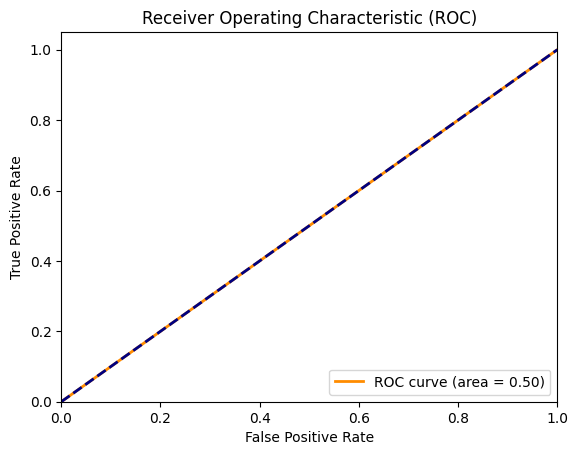

Registered model 'Dummy_Baseline_Model' already exists. Creating a new version of this model...
Created version '2' of model 'Dummy_Baseline_Model'.


In [24]:
with mlflow.start_run(run_name="Dummy_Baseline_small"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU.
    monitor = ResourceMonitor(interval=1)
    monitor.start()

    # Création et entraînement du modèle DummyClassifier.
    dummy_small = DummyClassifier(strategy='most_frequent', random_state=42)
    dummy_small.fit(X_train_small, y_train_small)

    # Prédiction et évaluation du modèle sur l'ensemble de test.
    y_pred = dummy_small.predict(X_test_small)
    y_proba = dummy_small.predict_proba(X_test_small)[:, 1]

    # Enregistrement des paramètres du modèle dans MLFlow.
    mlflow.log_param("strategy", 'most_frequent')

    # Calcul et enregistrement des métriques de performance dans MLFlow.
    metrics = {
        "accuracy": accuracy_score(y_test_small, y_pred),
        "precision": precision_score(y_test_small, y_pred, zero_division=0),
        "recall": recall_score(y_test_small, y_pred, zero_division=0),
        "f1": f1_score(y_test_small, y_pred, zero_division=0),
    }
    mlflow.log_metrics(metrics)

    # Arrêt du moniteur de ressources et enregistrement des données de suivi.
    memory_usage, cpu_usage = monitor.stop()
    monitor.join()
    for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
        mlflow.log_metric("Memory_usage_mo", memory, step=step)
        mlflow.log_metric("CPU_usage_percent", cpu, step=step)

    # Affichage du rapport de classification.
    display(classification_report(y_test_small, y_pred))

    # Tracé et enregistrement de la courbe ROC.
    fpr, tpr, thresholds = roc_curve(y_test_small, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig("roc_auc_curve.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("roc_auc_curve.png")

    # Enregistrement du modèle Dummy dans MLFlow.
    mlflow.sklearn.log_model(
        sk_model=dummy_small,
        artifact_path="dummy_baseline",
        registered_model_name="Dummy_Baseline_Model"
    )

    model_path = os.path.join(models_path, "dummy_small.pkl")
    joblib.dump(dummy_small, model_path)

mlflow.end_run()

### CountVectorizer + LogisticRegression

Cette approche combine `CountVectorizer`, qui convertit le texte en un vecteur de fréquence de mots, avec un modèle de régression logistique, un classificateur linéaire populaire. Cette méthode est efficace pour des tâches de classification de texte car elle prend en compte la fréquence des mots comme caractéristique principale pour l'entraînement du modèle. Cependant, elle ne tient pas compte de l'importance relative des mots dans différents documents.

In [25]:
mlflow.set_experiment("Regression Logistique")

with mlflow.start_run(run_name="CountVectorizer_LogisticRegression_GridSearch"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU
    monitor = ResourceMonitor(interval=1)
    monitor.start()

    # Définition du pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', LogisticRegression(solver='liblinear'))
    ])

    # Définition de la grille de recherche des hyperparamètres
    param_grid = {
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.1, 1.0, 10],
        'clf__max_iter': [100,500,1000,2000],
        'clf__random_state': [42]
    }

    # Initialisation de la recherche sur la grille
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=2, scoring='roc_auc', n_jobs=10, verbose=2)

    # Exécution de la recherche sur la grille
    grid_search.fit(X_train, y_train)

    # Récupération des meilleurs paramètres et modèle
    best_params = grid_search.best_params_
    model_count_log = grid_search.best_estimator_
    mlflow.log_params(best_params)

    del pipeline
    del param_grid
    del grid_search

    # Prédiction avec le meilleur modèle
    y_pred = model_count_log.predict(X_test)
    y_proba = model_count_log.predict_proba(X_test)[:, 1]

    # Calcul et enregistrement des métriques de performance dans MLFlow
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "pr_auc": average_precision_score(y_test, y_proba)
    }
    mlflow.log_metrics(metrics)

    # Arrêt du moniteur de ressources et enregistrement des données de suivi
    memory_usage, cpu_usage = monitor.stop()
    monitor.join()
    for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
        mlflow.log_metric("Memory_usage_mo", memory, step=step)
        mlflow.log_metric("CPU_usage_percent", cpu, step=step)


    # Affichage du rapport de classification
    display(classification_report(y_test, y_pred))

    # Tracé et enregistrement de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig("roc_auc_curve.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("roc_auc_curve.png")

    # Inférence de la signature du modèle pour MLFlow
    signature = infer_signature(X_test, y_pred)

    # Enregistrement du meilleur modèle dans MLFlow
    mlflow.sklearn.log_model(
        sk_model=model_count_log,
        artifact_path="count_vectorizer_log_reg_grid",
        signature=signature,
        registered_model_name="CountVectorizer_LogReg_Grid_Model"
    )

    model_path = os.path.join(models_path, "model_count_log.pkl")
    joblib.dump(model_count_log, model_path)

mlflow.end_run()

2024/03/07 14:20:11 INFO mlflow.tracking.fluent: Experiment with name 'Regression Logistique' does not exist. Creating a new experiment.


Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l1, clf__random_state=42; total time=   9.8s
[CV] END clf__C=0.1, clf__max_iter=500, clf__penalty=l1, clf__random_state=42; total time=  11.1s
[CV] END clf__C=0.1, clf__max_iter=500, clf__penalty=l1, clf__random_state=42; total time=  11.5s
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l1, clf__random_state=42; total time=  14.2s
[CV] END clf__C=0.1, clf__max_iter=1000, clf__penalty=l1, clf__random_state=42; total time=  12.5s
[CV] END clf__C=0.1, clf__max_iter=1000, clf__penalty=l1, clf__random_state=42; total time=  14.5s
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l2, clf__random_state=42; total time=  20.7s
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l2, clf__random_state=42; total time=  20.4s
[CV] END clf__C=0.1, clf__max_iter=500, clf__penalty=l2, clf__random_state=42; total time=  22.3s
[CV] END clf__C=0.1, clf__max_iter=2000, clf__penalty=l

/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10, clf__max_iter=100, clf__penalty=l2, clf__random_state=42; total time= 3.3min
[CV] END clf__C=10, clf__max_iter=500, clf__penalty=l2, clf__random_state=42; total time= 3.7min
[CV] END clf__C=10, clf__max_iter=2000, clf__penalty=l2, clf__random_state=42; total time= 3.5min
[CV] END clf__C=10, clf__max_iter=1000, clf__penalty=l2, clf__random_state=42; total time= 3.7min


'              precision    recall  f1-score   support\n\n           0       0.80      0.76      0.78    156836\n           1       0.77      0.81      0.79    155937\n\n    accuracy                           0.79    312773\n   macro avg       0.79      0.79      0.79    312773\nweighted avg       0.79      0.79      0.79    312773\n'

Successfully registered model 'CountVectorizer_LogReg_Grid_Model'.
Created version '1' of model 'CountVectorizer_LogReg_Grid_Model'.


### TfidfVectorizer + LogisticRegression

`TfidfVectorizer` convertit le texte en un vecteur de fréquence de mots pondérée par TF-IDF (Term Frequency-Inverse Document Frequency), qui reflète non seulement la fréquence des mots mais aussi leur importance dans le corpus. Combiné à la régression logistique, cette méthode est particulièrement puissante pour distinguer les mots pertinents des mots communs et peu informatifs dans les tâches de classification de texte.

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l1, clf__random_state=42; total time=  16.3s
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l1, clf__random_state=42; total time=  16.3s
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l1, clf__random_state=42; total time=  17.7s
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l1, clf__random_state=42; total time=  17.7s
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l2, clf__random_state=42; total time=  21.5s
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l1, clf__random_state=42; total time=  22.9s
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l2, clf__random_state=42; total time=  22.9s
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l2, clf__random_state=42; total time=  25.5s
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l2, clf__random_state=42; total time=  28.1s
[CV] END clf__C=0.1, clf__max_iter=100, clf__penalty=l2,

'              precision    recall  f1-score   support\n\n           0       0.80      0.78      0.79    156836\n           1       0.78      0.80      0.79    155937\n\n    accuracy                           0.79    312773\n   macro avg       0.79      0.79      0.79    312773\nweighted avg       0.79      0.79      0.79    312773\n'

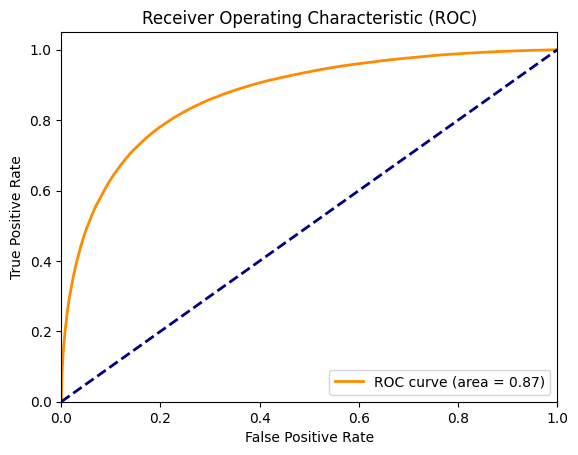

Successfully registered model 'TfidfVectorizer_LogReg_Grid_Model'.
Created version '1' of model 'TfidfVectorizer_LogReg_Grid_Model'.


In [26]:
with mlflow.start_run(run_name="TfidfVectorizer_LogisticRegression_GridSearch"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU
    monitor = ResourceMonitor(interval=1)
    monitor.start()

    # Définition du pipeline
    pipeline = Pipeline([
        ('vect', TfidfVectorizer()),
        ('clf', LogisticRegression(solver='liblinear'))
    ])

    # Définition de la grille de recherche des hyperparamètres
    param_grid = {
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.1, 1.0, 10],
        'clf__max_iter': [100, 500, 1000, 2000],
        'clf__random_state': [42]
    }

    # Initialisation de la recherche sur la grille
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=10, verbose=2)

    # Exécution de la recherche sur la grille
    grid_search.fit(X_train, y_train)

    # Récupération des meilleurs paramètres et modèle
    best_params = grid_search.best_params_
    model_tfidf_log = grid_search.best_estimator_
    mlflow.log_params(best_params)

    del pipeline
    del param_grid
    del grid_search

    # Prédiction avec le meilleur modèle
    y_pred = model_tfidf_log.predict(X_test)
    y_proba = model_tfidf_log.predict_proba(X_test)[:, 1]

    # Calcul et enregistrement des métriques de performance dans MLFlow
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "pr_auc": average_precision_score(y_test, y_proba)
    }
    mlflow.log_metrics(metrics)

    # Arrêt du moniteur de ressources et enregistrement des données de suivi
    memory_usage, cpu_usage = monitor.stop()
    monitor.join()
    for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
        mlflow.log_metric("Memory_usage_mo", memory, step=step)
        mlflow.log_metric("CPU_usage_percent", cpu, step=step)

    # Affichage du rapport de classification
    display(classification_report(y_test, y_pred))

    # Tracé et enregistrement de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig("roc_auc_curve.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("roc_auc_curve.png")

    # Inférence de la signature du modèle pour MLFlow
    signature = infer_signature(X_test, y_pred)
    
    # Enregistrement du meilleur modèle dans MLFlow
    mlflow.sklearn.log_model(
        sk_model=model_tfidf_log,
        artifact_path="tfidf_vectorizer_log_reg_grid",
        signature=signature,
        registered_model_name="TfidfVectorizer_LogReg_Grid_Model"
    )

    model_path = os.path.join(models_path, "model_tfidf_log.pkl")
    joblib.dump(model_tfidf_log, model_path)

mlflow.end_run()

## Modèle sur mesure avancé

Après avoir exploré des modèles de base, nous nous tournons maintenant vers des architectures de réseaux de neurones plus sophistiquées pour améliorer nos performances. Les modèles FFNN (Feedforward Neural Networks) avec des couches d'embedding représentent une approche puissante pour le traitement du langage naturel (NLP). Ces modèles nous permettent de capturer des représentations denses des mots, où chaque mot est mappé à un vecteur de caractéristiques dans un espace continu, facilitant ainsi la capture de relations sémantiques entre les mots.

### FFNN models with Embedding layer

Les couches d'embedding sont fondamentales dans le traitement du langage naturel car elles transforment les tokens (mots) en vecteurs de faible dimension. Cela permet au réseau de neurones de traiter efficacement le texte en entrée. Nous allons implémenter des modèles FFNN qui intègrent ces couches d'embedding pour analyser les sentiments exprimés dans des tweets.

In [10]:
mlflow.set_experiment("Embedding")

<Experiment: artifact_location=('file:///home/nlombard/Nextcloud/Documents/Perso/Formation/Ingenieur '
 'IA/Project 7/mlruns/208332749136081560'), creation_time=1709818688440, experiment_id='208332749136081560', last_update_time=1709818688440, lifecycle_stage='active', name='Embedding', tags={}>

#### Couche d'embedding sur texte encodé simplement

Pour commencer, nous allons encoder notre texte à l'aide d'un Tokenizer, qui convertira nos mots en indices. Ces indices seront ensuite passés à une couche d'embedding, où chaque indice sera mappé à un vecteur dense. Ce processus permet de réduire la dimensionnalité du texte et de capturer des informations sémantiques.

In [28]:
with mlflow.start_run(run_name="FFNN_with_Embedding"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU
    monitor = ResourceMonitor(interval=1)
    monitor.start()

    # Tokenisation des données
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Remplissage des séquences pour qu'elles aient toutes la même longueur
    X_train_pad = pad_sequences(X_train_seq, maxlen=512)
    X_test_pad = pad_sequences(X_test_seq, maxlen=512)

    # Définition du modèle séquentiel
    model_embedding_simple = Sequential()
    model_embedding_simple.add(Embedding(input_dim=5000, output_dim=50, input_length=512))
    model_embedding_simple.add(Flatten())
    model_embedding_simple.add(Dense(10, activation='relu'))
    model_embedding_simple.add(Dense(10, activation='relu'))
    model_embedding_simple.add(Dense(1, activation='sigmoid'))

    model_embedding_simple.summary()

    # Compilation du modèle
    model_embedding_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

    # Entraînement du modèle
    model_embedding_simple.fit(X_train_pad, y_train, epochs=10, validation_split=0.2)
    
    # Évaluation du modèle sur les données de test
    loss, accuracy = model_embedding_simple.evaluate(X_test_pad, y_test)
    mlflow.log_metrics({'loss': loss, 'accuracy': accuracy})

    # Arrêt du moniteur de ressources et enregistrement des données de suivi
    memory_usage, cpu_usage = monitor.stop()
    monitor.join()
    for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
        mlflow.log_metric("Memory_usage_mo", memory, step=step)
        mlflow.log_metric("CPU_usage_percent", cpu, step=step)

    # Prédiction des probabilités sur les données de test
    y_proba = model_embedding_simple.predict(X_test_pad)
    
    # Tracé et enregistrement de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig("roc_auc_curve.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("roc_auc_curve.png")

    # Enregistrement du meilleur modèle dans MLFlow
    mlflow.sklearn.log_model(
        sk_model=model_embedding_simple,
        artifact_path="ffnn_with_embedding_model",
        registered_model_name="FFNN_with_Embedding_Model"
    )
    
    mlflow.keras.log_model(model_embedding_simple, "FFNN_with_Embedding_Model")

    models_path_model = models_path+'model_embedding_simple/'
    model_path = os.path.join(models_path_model, "model_embedding_simple")
    model_embedding_simple.save(models_path_model)

    # Enregistrer du tokenizer
    with open(os.path.join(models_path_model, "tokenizer.json"), 'w', encoding='utf-8') as f:
        f.write(tokenizer.to_json())

    del tokenizer,models_path_model
    del X_train_seq,X_test_seq
    del X_train_pad,X_test_pad
mlflow.end_run()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 50)           250000    
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 10)                256010    
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 506131 (1.93 MB)
Trainable params: 506131 (1.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


2024-03-07 14:38:28.633604: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1816852480 exceeds 10% of free system memory.


27711/27723 [============================>.] - ETA: 0s - loss: 0.4740 - auc: 0.8550

2024-03-07 14:40:11.021774: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 454213632 exceeds 10% of free system memory.


27723/27723 [==============================] - 108s 4ms/step - loss: 0.4740 - auc: 0.8550 - val_loss: 0.4562 - val_auc: 0.8679
Epoch 2/10
27723/27723 [==============================] - 106s 4ms/step - loss: 0.4486 - auc: 0.8715 - val_loss: 0.4511 - val_auc: 0.8704
Epoch 3/10
27723/27723 [==============================] - 112s 4ms/step - loss: 0.4384 - auc: 0.8778 - val_loss: 0.4568 - val_auc: 0.8700
Epoch 4/10
27723/27723 [==============================] - 106s 4ms/step - loss: 0.4284 - auc: 0.8838 - val_loss: 0.4541 - val_auc: 0.8697
Epoch 5/10
27723/27723 [==============================] - 108s 4ms/step - loss: 0.4192 - auc: 0.8891 - val_loss: 0.4554 - val_auc: 0.8685
Epoch 6/10
27723/27723 [==============================] - 109s 4ms/step - loss: 0.4107 - auc: 0.8939 - val_loss: 0.4608 - val_auc: 0.8663
Epoch 7/10
27723/27723 [==============================] - 117s 4ms/step - loss: 0.4031 - auc: 0.8980 - val_loss: 0.4688 - val_auc: 0.8630
Epoch 8/10
27723/27723 [=====================

2024-03-07 14:56:52.751024: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 640559104 exceeds 10% of free system memory.


  87/9775 [..............................] - ETA: 11s

2024-03-07 14:57:05.837488: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 640559104 exceeds 10% of free system memory.


9775/9775 [==============================] - 11s 1ms/step


Successfully registered model 'FFNN_with_Embedding_Model'.
Created version '1' of model 'FFNN_with_Embedding_Model'.
2024/03/07 14:57:22 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp86u86n71/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp86u86n71/model/data/model/assets


INFO:tensorflow:Assets written to: models/model_embedding_simple/assets


INFO:tensorflow:Assets written to: models/model_embedding_simple/assets


#### Embedding FastText

FastText est une méthode d'embedding qui prend en compte la structure des mots en utilisant des n-grammes. Cela permet de mieux gérer les mots rares ou mal orthographiés en capturant des sous-chaînes de caractères significatives. Nous allons utiliser les embeddings pré-entraînés FastText pour enrichir notre modèle FFNN.

In [29]:
with mlflow.start_run(run_name="FFNN_with_FastText"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU
    monitor = ResourceMonitor(interval=1)
    monitor.start()

    # Tokenisation des données
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index

    # Chargement du modèle FastText pré-entraîné
    fasttext_model = fasttext.load_model('lid.176.ftz')

    # Création de la matrice d'embedding à partir du modèle FastText
    vocab_size = len(fasttext_model.get_words())  
    embedding_dim = fasttext_model.get_dimension()  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for i, word in enumerate(fasttext_model.get_words()):
        embedding_matrix[i] = fasttext_model.get_word_vector(word)

    # Conversion des textes en séquences et rembourrage des séquences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    X_train_pad = pad_sequences(X_train_seq, maxlen=512)
    X_test_pad = pad_sequences(X_test_seq, maxlen=512)

    # Définition du modèle séquentiel avec une couche d'embedding pré-entraînée
    model_embedding_fast = Sequential()
    model_embedding_fast.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=512,
        weights=[embedding_matrix]))
    model_embedding_fast.add(Flatten())
    model_embedding_fast.add(Dense(10, activation='relu'))
    model_embedding_fast.add(Dense(10, activation='relu'))
    model_embedding_fast.add(Dense(1, activation='sigmoid'))

    model_embedding_fast.summary()
    
    # Compilation du modèle
    model_embedding_fast.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

    # Entraînement du modèle
    history = model_embedding_fast.fit(X_train_pad, y_train, epochs=10, validation_split=0.2)

    # Prédiction des probabilités sur les données de test
    y_proba = model_embedding_fast.predict(X_test_pad)
    
    # Évaluation du modèle sur les données de test
    loss, accuracy = model_embedding_fast.evaluate(X_test_pad, y_test)
    mlflow.log_metrics({'loss': loss, 'accuracy': accuracy})

    # Arrêt du moniteur de ressources et enregistrement des données de suivi
    memory_usage, cpu_usage = monitor.stop()
    monitor.join()
    for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
        mlflow.log_metric("Memory_usage_mo", memory, step=step)
        mlflow.log_metric("CPU_usage_percent", cpu, step=step)
        
    # Tracé et enregistrement de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig("roc_auc_curve.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("roc_auc_curve.png")

    # Enregistrement du meilleur modèle dans MLFlow
    mlflow.sklearn.log_model(
        sk_model=model_embedding_fast,
        artifact_path="ffnn_with_fasttext_model",
        registered_model_name="FFNN_with_FastText_Model"
    )
    
    mlflow.keras.log_model(model_embedding_fast, "FFNN_with_FastText_Model")

    # Enregistrer le model
    models_path_model = models_path+'model_fastText/'
    model_path = os.path.join(models_path_model, "model_fastText")
    model_embedding_fast.save(models_path_model)

    # Enregistrer le tokenizer
    with open(os.path.join(models_path_model, "tokenizer.json"), 'w', encoding='utf-8') as f:
        f.write(tokenizer.to_json())

    del tokenizer
    del X_train_seq,X_test_seq
    del X_train_pad,X_test_pad
mlflow.end_run()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 16)           640160    
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                81930     
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 722211 (2.76 MB)
Trainable params: 722211 (2.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


2024-03-07 14:57:49.790146: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1816852480 exceeds 10% of free system memory.


27723/27723 [==============================] - 110s 4ms/step - loss: 0.5044 - auc_1: 0.8336 - val_loss: 0.4664 - val_auc_1: 0.8620
Epoch 2/10
27723/27723 [==============================] - 108s 4ms/step - loss: 0.4604 - auc_1: 0.8644 - val_loss: 0.4570 - val_auc_1: 0.8670
Epoch 3/10
27723/27723 [==============================] - 104s 4ms/step - loss: 0.4514 - auc_1: 0.8700 - val_loss: 0.4569 - val_auc_1: 0.8694
Epoch 4/10
27723/27723 [==============================] - 104s 4ms/step - loss: 0.4452 - auc_1: 0.8739 - val_loss: 0.4492 - val_auc_1: 0.8716
Epoch 5/10
27723/27723 [==============================] - 108s 4ms/step - loss: 0.4405 - auc_1: 0.8767 - val_loss: 0.4492 - val_auc_1: 0.8718
Epoch 6/10
27723/27723 [==============================] - 106s 4ms/step - loss: 0.4370 - auc_1: 0.8788 - val_loss: 0.4491 - val_auc_1: 0.8723
Epoch 7/10
27723/27723 [==============================] - 112s 4ms/step - loss: 0.4339 - auc_1: 0.8806 - val_loss: 0.4525 - val_auc_1: 0.8721
Epoch 8/10
27723/

Successfully registered model 'FFNN_with_FastText_Model'.
Created version '1' of model 'FFNN_with_FastText_Model'.
2024/03/07 15:16:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpiypk2adn/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpiypk2adn/model/data/model/assets


INFO:tensorflow:Assets written to: models/model_fastText/assets


INFO:tensorflow:Assets written to: models/model_fastText/assets


#### Embedding Glove

GloVe (Global Vectors) est une autre approche d'embedding qui se concentre sur les co-occurrences des mots dans un corpus. Les vecteurs GloVe capturent des relations globales entre les mots, ce qui peut améliorer la compréhension sémantique des mots dans le modèle.

In [30]:
with mlflow.start_run(run_name="FFNN_with_GloVe"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU
    monitor = ResourceMonitor(interval=1)
    monitor.start()

    # Tokenisation des données
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index

    embedding_dim = 100
    glove_dir = 'data/RAW/glove/glove.twitter.27B.100d.txt'

    # Chargement des embeddings de GloVe
    embeddings_index = {}
    with open(glove_dir, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Création de la matrice d'embeddings
    embedding_matrix = np.zeros((5000, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < 5000:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    # Conversion des textes en séquences et rembourrage des séquences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Définition du modèle séquentiel avec une couche d'embedding pré-entraînée de GloVe
    X_train_pad = pad_sequences(X_train_seq, maxlen=512)
    X_test_pad = pad_sequences(X_test_seq, maxlen=512)

    model_embedding_glove = Sequential()
    model_embedding_glove.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=512, weights=[embedding_matrix], trainable=False))
    model_embedding_glove.add(Flatten())
    model_embedding_glove.add(Dense(10, activation='relu'))
    model_embedding_glove.add(Dense(10, activation='relu'))
    model_embedding_glove.add(Dense(1, activation='sigmoid'))

    model_embedding_glove.summary()

    # Compilation du modèle
    model_embedding_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

    # Entraînement du modèle
    history = model_embedding_glove.fit(X_train_pad, y_train, epochs=10, validation_split=0.2)

    # Prédiction des probabilités sur les données de test
    y_proba = model_embedding_glove.predict(X_test_pad)
    
    # Évaluation du modèle sur les données de test
    loss, accuracy = model_embedding_glove.evaluate(X_test_pad, y_test)
    mlflow.log_metrics({'loss': loss, 'accuracy': accuracy})

    # Arrêt du moniteur de ressources et enregistrement des données de suivi
    memory_usage, cpu_usage = monitor.stop()
    monitor.join()
    for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
        mlflow.log_metric("Memory_usage_mo", memory, step=step)
        mlflow.log_metric("CPU_usage_percent", cpu, step=step)
        
    # Tracé et enregistrement de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig("roc_auc_curve.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("roc_auc_curve.png")

    # Enregistrement du meilleur modèle dans MLFlow
    mlflow.sklearn.log_model(
        sk_model=model_embedding_glove,
        artifact_path="ffnn_with_glove_model",
        registered_model_name="FFNN_with_GloVe_Model"
    )
    
    mlflow.keras.log_model(model_embedding_glove, "FFNN_with_GloVe_Model")

    # Enregistrer le model
    models_path_model = models_path+'model_glove/'
    model_path: str = os.path.join(models_path_model, "model_glove")
    model_embedding_glove.save(models_path_model)

    # Enregistrer le tokenizer
    with open(os.path.join(models_path_model, "tokenizer.json"), 'w', encoding='utf-8') as f:
        f.write(tokenizer.to_json())

    del tokenizer
    del embedding_dim,embeddings_index,embedding_matrix
    del X_train_seq,X_test_seq
    del X_train_pad,X_test_pad
mlflow.end_run()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 100)          500000    
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 10)                512010    
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1012131 (3.86 MB)
Trainable params: 512131 (1.95 MB)
Non-trainable params: 500000 (1.91 MB)
_________________________________________________________________
Epoch 1/10
277

Successfully registered model 'FFNN_with_GloVe_Model'.
Created version '1' of model 'FFNN_with_GloVe_Model'.
2024/03/07 15:36:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpi8ugmj9d/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpi8ugmj9d/model/data/model/assets


INFO:tensorflow:Assets written to: models/model_glove/assets


INFO:tensorflow:Assets written to: models/model_glove/assets


#### USE Universal Sentence Encoder (codeur universel de phrases)

L'Universal Sentence Encoder encode des phrases entières en vecteurs de haute dimension. Cet encodeur est particulièrement utile pour les tâches de comparaison sémantique de phrases et de textes. Nous l'utiliserons pour transformer nos données textuelles en embeddings de phrases.


In [11]:
with mlflow.start_run(run_name="USE_Text_Classification"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU
    monitor = ResourceMonitor(interval=1)
    monitor.start()
    
    class USEEmbeddingLayer(tf.keras.layers.Layer):
        def __init__(self, model_url, **kwargs):
            super(USEEmbeddingLayer, self).__init__(**kwargs)
            self.model_url = model_url
            self.use = hub.load(self.model_url)

        def call(self, inputs):
            return self.use(inputs)
        
    # Définir le modèle séquentiel
    model_use = Sequential([
        # Utiliser USE pour convertir des phrases en vecteurs
        USEEmbeddingLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string),
        # Ajouter des couches pour la classification
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')  # Utilisez 'sigmoid' pour la classification binaire
    ])

    # Compiler le modèle avec l'optimiseur 'adam' et la perte 'binary_crossentropy'
    model_use.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=[AUC()])

    # Entraîner le modèle avec les données d'entraînement pour un certain nombre d'époques avec une validation croisée
    history = model_use.fit(x=tf.convert_to_tensor(X_train), 
                        y=y_train, 
                        epochs=10, 
                        validation_split=0.2)

    # Évaluer le modèle sur l'ensemble de test pour obtenir la perte et la précision
    loss, accuracy = model_use.evaluate(tf.convert_to_tensor(X_test), y_test)
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

    # Enregistrer les métriques dans MLflow
    mlflow.log_metrics({'loss': loss, 'accuracy': accuracy})

    # Arrêt du moniteur de ressources et enregistrement des données de suivi
    memory_usage, cpu_usage = monitor.stop()
    monitor.join()
    for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
        mlflow.log_metric("Memory_usage_mo", memory, step=step)
        mlflow.log_metric("CPU_usage_percent", cpu, step=step)

    # Prédire les probabilités et calculer la courbe ROC
    y_proba = model_use.predict(tf.convert_to_tensor(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Tracé et enregistrement de la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig("roc_auc_curve_use.png")
    plt.close()

    # Enregistrer la courbe ROC dans MLflow
    mlflow.log_artifact("roc_auc_curve_use.png")

    # Enregistrer le modèle dans MLflow
    mlflow.tensorflow.log_model(model_use,
                            artifact_path="use_text_classification_model",
                            registered_model_name="USE_Text_Classification_Model")
    

    model_path = os.path.join(models_path, "model_use")
    model_use.save(model_path)

    
    del model_use

mlflow.end_run()

Epoch 1/10
27723/27723 [==============================] - 286s 10ms/step - loss: 0.4669 - auc: 0.8589 - val_loss: 0.4567 - val_auc: 0.8660
Epoch 2/10
27723/27723 [==============================] - 281s 10ms/step - loss: 0.4498 - auc: 0.8702 - val_loss: 0.4518 - val_auc: 0.8694
Epoch 3/10
27723/27723 [==============================] - 277s 10ms/step - loss: 0.4406 - auc: 0.8760 - val_loss: 0.4520 - val_auc: 0.8702
Epoch 4/10
27723/27723 [==============================] - 284s 10ms/step - loss: 0.4332 - auc: 0.8805 - val_loss: 0.4507 - val_auc: 0.8699
Epoch 5/10
27723/27723 [==============================] - 287s 10ms/step - loss: 0.4266 - auc: 0.8844 - val_loss: 0.4516 - val_auc: 0.8699
Epoch 6/10
27723/27723 [==============================] - 282s 10ms/step - loss: 0.4210 - auc: 0.8877 - val_loss: 0.4547 - val_auc: 0.8689
Epoch 7/10
27723/27723 [==============================] - 283s 10ms/step - loss: 0.4160 - auc: 0.8906 - val_loss: 0.4556 - val_auc: 0.8682
Epoch 8/10
27723/27723 [===

2024/03/14 16:12:58 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp9esmy1jx/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp9esmy1jx/model/data/model/assets
/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'USE_Text_Classification_Model' already exists. Creating a new version of this model...
Created version '2' of model 'USE_Text_Classification_Model'.


INFO:tensorflow:Assets written to: models/model_use/assets


INFO:tensorflow:Assets written to: models/model_use/assets


## Modèle sur mesure avancé LLM

Les modèles basés sur des transformateurs, tels que BERT et Mixtral-8x7B, représentent l'état de l'art pour de nombreuses tâches de NLP. Ces modèles tirent parti d'une architecture de réseau profond pour capturer un large contexte et comprendre la structure complexe du langage.

In [11]:
mlflow.set_experiment("LLM")

<Experiment: artifact_location=('file:///home/nlombard/Nextcloud/Documents/Perso/Formation/Ingenieur '
 'IA/Project 7/mlruns/856125421810925636'), creation_time=1709822207496, experiment_id='856125421810925636', last_update_time=1709822207496, lifecycle_stage='active', name='LLM', tags={}>

### Couche d'intégration sur le texte encodé par Bert

BERT (Bidirectional Encoder Representations from Transformers) utilise une approche bidirectionnelle pour comprendre le contexte d'un mot par rapport à tous les autres mots dans une phrase. Nous allons exploiter la puissance de BERT pour créer des embeddings riches pour notre modèle.

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

988/988 [==============================] - 5708s 6s/step - loss: 0.5231 - auc: 0.8186


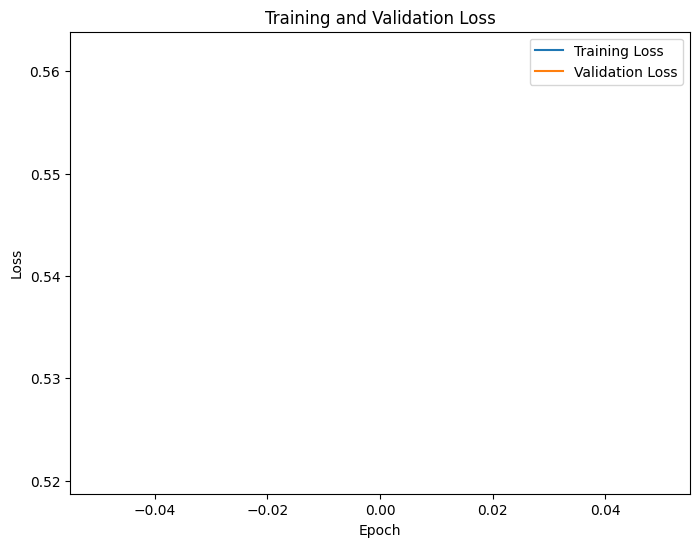

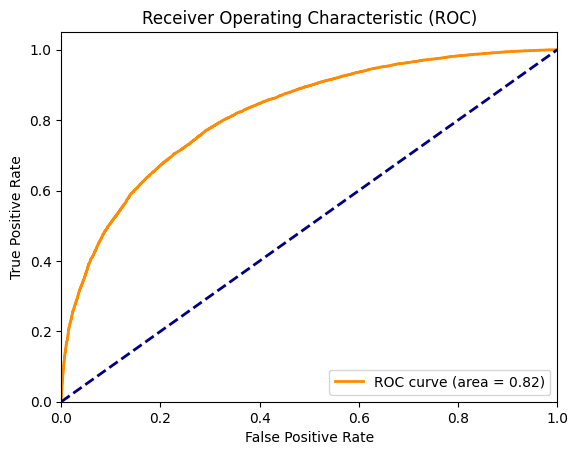

/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
2024/03/13 04:34:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpdl2_a4xg/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.4.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback.
/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'FFNN_with_BERT_Model'.
Created version '1' of model 'FFNN_with_BERT_Model'.
2024/03/13 04:34:57 WARNING mlflow.tensorflow

INFO:tensorflow:Assets written to: /tmp/tmpd1v9n4kt/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpd1v9n4kt/model/data/model/assets
2024/03/13 04:35:27 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpd1v9n4kt/model, flavor: tensorflow), fall back to return ['tensorflow==2.15.0.post1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback.


INFO:tensorflow:Assets written to: models/model_bert/model_BERT/assets


INFO:tensorflow:Assets written to: models/model_bert/model_BERT/assets


In [12]:
with mlflow.start_run(run_name="FFNN_with_BERT"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU
    monitor = ResourceMonitor(interval=1)
    monitor.start()

    # Chargement du tokenizer et du modèle BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    bert_model.trainable = False

    # Fonction pour préparer les données en tokenisant et en préparant les inputs
    max_length = 256

    def prepare_data(texts):
        input_ids = []
        attention_masks = []

        for text in texts:
            inputs = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, pad_to_max_length=True, return_attention_mask=True, truncation=True, return_tensors='tf')
            input_ids.append(inputs['input_ids'])
            attention_masks.append(inputs['attention_mask'])

        return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

    # Préparation des données d'entraînement et de test
    X_train_ids, X_train_masks = prepare_data(X_train_small)
    X_test_ids, X_test_masks = prepare_data(X_test_small)

    # Définition du modèle avec BERT en tant que couche d'embedding
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

    bert_outputs = bert_model(input_ids, attention_mask=input_mask)
    last_hidden_state = bert_outputs.last_hidden_state

    # Utilisation de la première sortie (correspondant au token [CLS]) pour la classification
    cls_token = last_hidden_state[:, 0, :]
    out = Dense(10, activation='relu')(cls_token)
    out = Dense(1, activation='sigmoid')(out)

    model_bert = tf.keras.models.Model(inputs=[input_ids, input_mask], outputs=out)

    model_bert.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

    # Entraînement du modèle
    history = model_bert.fit([X_train_ids, X_train_masks], y_train_small, epochs=1, validation_split=0.2)

    # Prédiction des probabilités et évaluation du modèle
    y_proba = model_bert.predict([X_test_ids, X_test_masks])
    loss, accuracy = model_bert.evaluate([X_test_ids, X_test_masks], y_test_small)
    mlflow.log_metrics({'loss': loss, 'accuracy': accuracy})

    # Arrêt du moniteur de ressources et enregistrement des données de suivi
    memory_usage, cpu_usage = monitor.stop()
    monitor.join()
    for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
        mlflow.log_metric("Memory_usage_mo", memory, step=step)
        mlflow.log_metric("CPU_usage_percent", cpu, step=step)

    # Graphique de la perte de l'entraînement et de la validation
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.savefig("training_validation_loss_with_glove.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("training_validation_loss_with_glove.png")
        
    # Tracé et enregistrement de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test_small, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig("roc_auc_curve.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("roc_auc_curve.png")

    # Enregistrement du modèle dans MLFlow
    mlflow.sklearn.log_model(
        sk_model=model_bert,
        artifact_path="ffnn_with_bert_model",
        registered_model_name="FFNN_with_BERT_Model"
    )

    mlflow.keras.log_model(model_bert, "FFNN_with_BERT_Model")

    models_path_model = models_path+'model_bert/'
    model_path = os.path.join(models_path_model, "model_BERT")
    model_bert.save(model_path)

    tokenizer.save_pretrained(models_path_model+'tokenizer/')

    del tokenizer
    del input_ids,input_mask
    del bert_outputs,last_hidden_state
    del cls_token,out
        
mlflow.end_run()

## Modèles RNN (réseau neuronal récurrent)

Les modèles RNN sont particulièrement adaptés au traitement de séquences, comme le texte, car ils tiennent compte de l'ordre et du contexte des mots. Nous explorerons différents types de RNN pour notre tâche de classification de texte.

In [9]:
mlflow.set_experiment("from_scratch")

<Experiment: artifact_location=('file:///home/nlombard/Nextcloud/Documents/Perso/Formation/Ingenieur '
 'IA/Project 7/mlruns/469697220945943207'), creation_time=1709822604684, experiment_id='469697220945943207', last_update_time=1709822604684, lifecycle_stage='active', name='from_scratch', tags={}>

### RNN simple sur texte intégré

Un RNN simple est le type de réseau de neurones récurrent le plus basique. Malgré sa simplicité, il peut capturer des dépendances séquentielles dans les données textuelles pour une certaine profondeur.

In [35]:
with mlflow.start_run(run_name="RNN_Text_Classification"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU
    monitor = ResourceMonitor(interval=1)
    monitor.start()

    # Tokenisation des données
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Rembourrage des séquences pour qu'elles aient toutes la même longueur
    X_train_pad = pad_sequences(X_train_seq, maxlen=512)
    X_test_pad = pad_sequences(X_test_seq, maxlen=512)

    model_rnn = Sequential()
    # Couche d'embedding pour convertir les indices de mots en vecteurs denses
    model_rnn.add(Embedding(input_dim=5000, output_dim=50, input_length=512))
    # Utiliser un RNN simple pour traiter les séquences de mots
    model_rnn.add(SimpleRNN(units=128))
    # Ajouter des couches pour la classification
    model_rnn.add(Dense(1, activation='sigmoid'))

    # Compiler le modèle
    model_rnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[AUC()])

    # Obtenir le nom de la métrique ROC AUC à partir des metrics_names
    roc_auc_metric_name = next((metric for metric in model_rnn.metrics_names if metric.startswith('val_auc')), None)

    # Vérifier si la métrique ROC AUC a été trouvée
    if roc_auc_metric_name is not None:
        print("La métrique ROC AUC n'a pas été trouvée dans les metrics_names.")
    else:
        # Utiliser la métrique ROC AUC trouvée pour l'arrêt anticipé
        early_stopping_callback = EarlyStopping(monitor=roc_auc_metric_name, patience=3, mode='max', verbose=1)

        # Entraînement du modèle sur les données d'entraînement pour une époque avec une validation croisée
        history = model_rnn.fit(x=X_train_pad, y=y_train, epochs=10, validation_split=0.2,callbacks=[early_stopping_callback])

        # Évaluation du modèle sur l'ensemble de test pour obtenir la perte et la précision
        loss, accuracy = model_rnn.evaluate(X_test_pad, y_test)
        print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

        # Enregistrer les métriques dans MLflow
        mlflow.log_metrics({'loss': loss, 'accuracy': accuracy})

        # Arrêt du moniteur de ressources et enregistrement des données de suivi
        memory_usage, cpu_usage = monitor.stop()
        monitor.join()
        for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
            mlflow.log_metric("Memory_usage_mo", memory, step=step)
            mlflow.log_metric("CPU_usage_percent", cpu, step=step)

        # Prédiction des probabilités et calcul de la courbe ROC
        y_proba = model_rnn.predict(X_test_pad)
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Tracé et enregistrement de la courbe ROC
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.savefig("roc_auc_curve_rnn.png")
        plt.close()
        mlflow.log_artifact("roc_auc_curve_rnn.png")

        # Enregistrer le modèle dans MLflow
        mlflow.tensorflow.log_model(model_rnn,
                                artifact_path="rnn_text_classification_model",
                                registered_model_name="RNN_Text_Classification_Model")

        # Enregistrer le model
        models_path_model = models_path+'model_rnn/'
        model_path = os.path.join(models_path_model, "model_rnn")
        model_rnn.save(models_path_model)

        # Enregistrer le tokenizer
        with open(os.path.join(models_path_model, "tokenizer.json"), 'w', encoding='utf-8') as f:
            f.write(tokenizer.to_json())
    
    # Nettoyer les variables
    del tokenizer, X_train_seq, X_test_seq, X_train_pad, X_test_pad,models_path_model
    
mlflow.end_run()

Epoch 1/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4795 - auc_4: 0.8510WARNING:tensorflow:Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,auc_4,val_loss,val_auc_4


27723/27723 [==============================] - 1549s 56ms/step - loss: 0.4795 - auc_4: 0.8510 - val_loss: 0.4566 - val_auc_4: 0.8677
Epoch 2/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4484 - auc_4: 0.8716WARNING:tensorflow:Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,auc_4,val_loss,val_auc_4


27723/27723 [==============================] - 1698s 61ms/step - loss: 0.4484 - auc_4: 0.8716 - val_loss: 0.4444 - val_auc_4: 0.8744
Epoch 3/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4394 - auc_4: 0.8772WARNING:tensorflow:Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,auc_4,val_loss,val_auc_4


27723/27723 [==============================] - 1785s 64ms/step - loss: 0.4394 - auc_4: 0.8772 - val_loss: 0.4413 - val_auc_4: 0.8766
Epoch 4/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4344 - auc_4: 0.8802WARNING:tensorflow:Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,auc_4,val_loss,val_auc_4


27723/27723 [==============================] - 1745s 63ms/step - loss: 0.4344 - auc_4: 0.8802 - val_loss: 0.4409 - val_auc_4: 0.8775
Epoch 5/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4306 - auc_4: 0.8825WARNING:tensorflow:Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,auc_4,val_loss,val_auc_4


27723/27723 [==============================] - 1700s 61ms/step - loss: 0.4306 - auc_4: 0.8825 - val_loss: 0.4419 - val_auc_4: 0.8775
Epoch 6/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4286 - auc_4: 0.8837WARNING:tensorflow:Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,auc_4,val_loss,val_auc_4


27723/27723 [==============================] - 1778s 64ms/step - loss: 0.4286 - auc_4: 0.8837 - val_loss: 0.4416 - val_auc_4: 0.8766
Epoch 7/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4289 - auc_4: 0.8835WARNING:tensorflow:Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,auc_4,val_loss,val_auc_4


27723/27723 [==============================] - 1625s 59ms/step - loss: 0.4289 - auc_4: 0.8835 - val_loss: 0.4416 - val_auc_4: 0.8765
Epoch 8/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4295 - auc_4: 0.8833WARNING:tensorflow:Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,auc_4,val_loss,val_auc_4


27723/27723 [==============================] - 1739s 63ms/step - loss: 0.4295 - auc_4: 0.8833 - val_loss: 0.4431 - val_auc_4: 0.8753
Epoch 9/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4286 - auc_4: 0.8837WARNING:tensorflow:Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,auc_4,val_loss,val_auc_4


27723/27723 [==============================] - 1683s 61ms/step - loss: 0.4286 - auc_4: 0.8837 - val_loss: 0.4448 - val_auc_4: 0.8767
Epoch 10/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4278 - auc_4: 0.8843WARNING:tensorflow:Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,auc_4,val_loss,val_auc_4


9775/9775 [==============================] - 173s 18ms/step - loss: 0.4418 - auc_4: 0.8765
Test Loss: 0.4418255090713501, Test Accuracy: 0.8764616847038269
9775/9775 [==============================] - 172s 18ms/step


2024/03/07 20:32:57 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpkxlchlfn/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpkxlchlfn/model/data/model/assets
Successfully registered model 'RNN_Text_Classification_Model'.
Created version '1' of model 'RNN_Text_Classification_Model'.


INFO:tensorflow:Assets written to: models/model_rnn/assets


INFO:tensorflow:Assets written to: models/model_rnn/assets


#### LSTM sur texte intégré

LSTM (Long Short-Term Memory) est une amélioration des RNN qui résout le problème de la disparition du gradient en introduisant des cellules de mémoire. Cela permet au modèle de se souvenir des informations sur de longues distances dans le texte.

In [36]:
with mlflow.start_run(run_name="LSTM_Text_Classification"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU
    monitor = ResourceMonitor(interval=1)
    monitor.start()

    # Tokenisation des données
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Rembourrage des séquences pour qu'elles aient toutes la même longueur
    X_train_pad = pad_sequences(X_train_seq, maxlen=512)
    X_test_pad = pad_sequences(X_test_seq, maxlen=512)

    # Définition du modèle séquentiel
    model_lstm = Sequential()
    # Couche d'embedding pour convertir les indices de mots en vecteurs denses
    model_lstm.add(Embedding(input_dim=5000, output_dim=50, input_length=512))
    # Utilisation d'une couche LSTM pour traiter les séquences de mots
    model_lstm.add(LSTM(units=128))
    # Ajout d'une couche dense pour la classification binaire
    model_lstm.add(Dense(1, activation='sigmoid'))

    # Compilation du modèle avec l'optimiseur 'adam' et la perte 'binary_crossentropy'
    model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

    # Obtenir le nom de la métrique ROC AUC à partir des metrics_names
    roc_auc_metric_name = next((metric for metric in model_lstm.metrics_names if metric.startswith('val_auc')), None)

    # Vérifier si la métrique ROC AUC a été trouvée
    if roc_auc_metric_name is not None:
        print("La métrique ROC AUC n'a pas été trouvée dans les metrics_names.")
    else:
        # Utiliser la métrique ROC AUC trouvée pour l'arrêt anticipé
        early_stopping_callback = EarlyStopping(monitor=roc_auc_metric_name, patience=3, mode='max', verbose=1)

        # Entraînement du modèle sur les données d'entraînement pour une époque avec une validation croisée
        history = model_lstm.fit(x=X_train_pad, y=y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping_callback])

        # Évaluation du modèle sur l'ensemble de test pour obtenir la perte et la précision
        loss, accuracy = model_lstm.evaluate(X_test_pad, y_test)
        print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

        mlflow.log_metrics({'loss': loss, 'accuracy': accuracy})

        # Arrêt du moniteur de ressources et enregistrement des données de suivi
        memory_usage, cpu_usage = monitor.stop()
        monitor.join()
        for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
            mlflow.log_metric("Memory_usage_mo", memory, step=step)
            mlflow.log_metric("CPU_usage_percent", cpu, step=step)

        # Prédiction des probabilités et calcul de la courbe ROC
        y_proba = model_lstm.predict(X_test_pad)
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Tracé et enregistrement de la courbe ROC
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.savefig("roc_auc_curve_lstm.png")
        plt.close()
        mlflow.log_artifact("roc_auc_curve_lstm.png")

        # Enregistrer le modèle dans MLflow
        mlflow.tensorflow.log_model(model_lstm,
                                artifact_path="lstm_text_classification_model",
                                registered_model_name="LSTM_Text_Classification_Model")

        # Enregistrer le model
        models_path_model = models_path+'model_lstm/'
        model_path = os.path.join(models_path_model, "model_lstm")
        model_lstm.save(models_path_model)

        # Enregistrer le tokenizer
        with open(os.path.join(models_path_model, "tokenizer.json"), 'w', encoding='utf-8') as f:
            f.write(tokenizer.to_json())
    
    del tokenizer,models_path_model
    del X_train_seq,X_test_seq
    del X_train_pad,X_test_pad
mlflow.end_run()


Epoch 1/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4485 - auc_5: 0.8713WARNING:tensorflow:Early stopping conditioned on metric `None` which is not available. Available metrics are: loss,auc_5,val_loss,val_auc_5


27723/27723 [==============================] - 4224s 152ms/step - loss: 0.4485 - auc_5: 0.8713 - val_loss: 0.4333 - val_auc_5: 0.8815
Epoch 2/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4214 - auc_5: 0.8877WARNING:tensorflow:Early stopping conditioned on metric `None` which is not available. Available metrics are: loss,auc_5,val_loss,val_auc_5


27723/27723 [==============================] - 4224s 152ms/step - loss: 0.4214 - auc_5: 0.8877 - val_loss: 0.4245 - val_auc_5: 0.8864
Epoch 3/10
27723/27723 [==============================] - ETA: 0s - loss: 0.4082 - auc_5: 0.8951WARNING:tensorflow:Early stopping conditioned on metric `None` which is not available. Available metrics are: loss,auc_5,val_loss,val_auc_5


27723/27723 [==============================] - 4127s 149ms/step - loss: 0.4082 - auc_5: 0.8951 - val_loss: 0.4229 - val_auc_5: 0.8868
Epoch 4/10
27723/27723 [==============================] - ETA: 0s - loss: 0.3967 - auc_5: 0.9013WARNING:tensorflow:Early stopping conditioned on metric `None` which is not available. Available metrics are: loss,auc_5,val_loss,val_auc_5


27723/27723 [==============================] - 4131s 149ms/step - loss: 0.3967 - auc_5: 0.9013 - val_loss: 0.4251 - val_auc_5: 0.8866
Epoch 5/10
27723/27723 [==============================] - ETA: 0s - loss: 0.3849 - auc_5: 0.9075WARNING:tensorflow:Early stopping conditioned on metric `None` which is not available. Available metrics are: loss,auc_5,val_loss,val_auc_5


27723/27723 [==============================] - 4118s 149ms/step - loss: 0.3849 - auc_5: 0.9075 - val_loss: 0.4279 - val_auc_5: 0.8851
Epoch 6/10
27723/27723 [==============================] - ETA: 0s - loss: 0.3722 - auc_5: 0.9138WARNING:tensorflow:Early stopping conditioned on metric `None` which is not available. Available metrics are: loss,auc_5,val_loss,val_auc_5


27723/27723 [==============================] - 4134s 149ms/step - loss: 0.3722 - auc_5: 0.9138 - val_loss: 0.4355 - val_auc_5: 0.8827
Epoch 7/10
27723/27723 [==============================] - ETA: 0s - loss: 0.3590 - auc_5: 0.9201WARNING:tensorflow:Early stopping conditioned on metric `None` which is not available. Available metrics are: loss,auc_5,val_loss,val_auc_5


27723/27723 [==============================] - 4109s 148ms/step - loss: 0.3590 - auc_5: 0.9201 - val_loss: 0.4452 - val_auc_5: 0.8792
Epoch 8/10
27723/27723 [==============================] - ETA: 0s - loss: 0.3458 - auc_5: 0.9261WARNING:tensorflow:Early stopping conditioned on metric `None` which is not available. Available metrics are: loss,auc_5,val_loss,val_auc_5


27723/27723 [==============================] - 4111s 148ms/step - loss: 0.3458 - auc_5: 0.9261 - val_loss: 0.4529 - val_auc_5: 0.8755
Epoch 9/10
27723/27723 [==============================] - ETA: 0s - loss: 0.3338 - auc_5: 0.9313WARNING:tensorflow:Early stopping conditioned on metric `None` which is not available. Available metrics are: loss,auc_5,val_loss,val_auc_5


27723/27723 [==============================] - 4113s 148ms/step - loss: 0.3338 - auc_5: 0.9313 - val_loss: 0.4675 - val_auc_5: 0.8740
Epoch 10/10
27723/27723 [==============================] - ETA: 0s - loss: 0.3224 - auc_5: 0.9361WARNING:tensorflow:Early stopping conditioned on metric `None` which is not available. Available metrics are: loss,auc_5,val_loss,val_auc_5


9775/9775 [==============================] - 477s 49ms/step - loss: 0.4771 - auc_5: 0.8699
Test Loss: 0.47708117961883545, Test Accuracy: 0.8698724508285522
9775/9775 [==============================] - 478s 49ms/step


2024/03/08 08:20:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpanfg_opt/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpanfg_opt/model/data/model/assets
Successfully registered model 'LSTM_Text_Classification_Model'.
Created version '1' of model 'LSTM_Text_Classification_Model'.


INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


### LSTM bidirectionnelle sur du texte intégré

Les BiLSTM améliorent les LSTM en parcourant les données dans les deux sens. Cela donne au modèle un contexte complet pour chaque point de données, améliorant sa capacité à comprendre le sens du texte.

In [12]:
with mlflow.start_run(run_name="BiLSTM_Text_Classification"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU
    monitor = ResourceMonitor(interval=1)
    monitor.start()

    # Tokenisation des données
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Rembourrage des séquences pour qu'elles aient toutes la même longueur
    X_train_pad = pad_sequences(X_train_seq, maxlen=512)
    X_test_pad = pad_sequences(X_test_seq, maxlen=512)

    # Définition du modèle séquentiel
    model_bilstm = Sequential()
    # Couche d'embedding pour convertir les indices de mots en vecteurs denses
    model_bilstm.add(Embedding(input_dim=5000, output_dim=50, input_length=512))
    # Utilisation d'une couche LSTM bidirectionnelle pour traiter les séquences de mots
    model_bilstm.add(Bidirectional(LSTM(units=128)))
    # Ajout d'une couche dense pour la classification binaire
    model_bilstm.add(Dense(1, activation='sigmoid'))

    # Compilation du modèle avec l'optimiseur 'adam' et la perte 'binary_crossentropy'
    model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

    # Obtenir le nom de la métrique ROC AUC à partir des metrics_names
    roc_auc_metric_name = next((metric for metric in model_bilstm.metrics_names if metric.startswith('val_auc')), None)

    # Vérifier si la métrique ROC AUC a été trouvée
    if roc_auc_metric_name is not None:
        print("La métrique ROC AUC n'a pas été trouvée dans les metrics_names.")
    else:
        # Utiliser la métrique ROC AUC trouvée pour l'arrêt anticipé
        early_stopping_callback = EarlyStopping(monitor=roc_auc_metric_name, patience=3, mode='max', verbose=1)
    
        # Entraînement du modèle sur les données d'entraînement pour une époque avec une validation croisée
        history = model_bilstm.fit(x=X_train_pad, y=y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping_callback])

        # Évaluation du modèle sur l'ensemble de test pour obtenir la perte et la précision
        loss, accuracy = model_bilstm.evaluate(X_test_pad, y_test)
        print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

        mlflow.log_metrics({'loss': loss, 'accuracy': accuracy})

        # Arrêt du moniteur de ressources et enregistrement des données de suivi
        memory_usage, cpu_usage = monitor.stop()
        monitor.join()
        for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
            mlflow.log_metric("Memory_usage_mo", memory, step=step)
            mlflow.log_metric("CPU_usage_percent", cpu, step=step)

        # Tracé et enregistrement de la courbe ROC
        y_proba = model_bilstm.predict(X_test_pad)
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.savefig("roc_auc_curve_bilstm.png")
        plt.close()

        mlflow.log_artifact("roc_auc_curve_bilstm.png")

        # Enregistrer le modèle dans MLflow
        mlflow.tensorflow.log_model(model_bilstm,
                                artifact_path="bilstm_text_classification_model",
                                registered_model_name="BiLSTM_Text_Classification_Model")
        
        # Enregistrer le model
        models_path_model = models_path+'model_bilstm/'
        model_path = os.path.join(models_path_model, "model_bilstm")
        model_bilstm.save(models_path_model)

        # Enregistrer le tokenizer
        with open(os.path.join(models_path_model, "tokenizer.json"), 'w', encoding='utf-8') as f:
            f.write(tokenizer.to_json())

    del tokenizer
    del X_train_seq,X_test_seq
    del X_train_pad,X_test_pad

mlflow.end_run()


Epoch 1/10


2024-03-08 17:29:17.962581: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1816852480 exceeds 10% of free system memory.


27723/27723 [==============================] - 6435s 232ms/step - loss: 0.4515 - auc: 0.8694 - val_loss: 0.4324 - val_auc: 0.8814
Epoch 2/10
27723/27723 [==============================] - 6031s 218ms/step - loss: 0.4230 - auc: 0.8867 - val_loss: 0.4248 - val_auc: 0.8860
Epoch 3/10
27723/27723 [==============================] - 5842s 211ms/step - loss: 0.4105 - auc: 0.8938 - val_loss: 0.4233 - val_auc: 0.8870
Epoch 4/10
27723/27723 [==============================] - 5762s 208ms/step - loss: 0.3997 - auc: 0.8997 - val_loss: 0.4235 - val_auc: 0.8870
Epoch 5/10
27723/27723 [==============================] - 5805s 209ms/step - loss: 0.3891 - auc: 0.9053 - val_loss: 0.4275 - val_auc: 0.8857
Epoch 6/10
27723/27723 [==============================] - 5684s 205ms/step - loss: 0.3780 - auc: 0.9109 - val_loss: 0.4325 - val_auc: 0.8839
Epoch 7/10
27723/27723 [==============================] - 5851s 211ms/step - loss: 0.3663 - auc: 0.9166 - val_loss: 0.4407 - val_auc: 0.8806
Epoch 8/10
27723/27723 [

2024/03/09 10:12:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpqnyglvhz/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpqnyglvhz/model/data/model/assets
/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'BiLSTM_Text_Classification_Model'.
Created version '1' of model 'BiLSTM_Text_Classification_Model'.


INFO:tensorflow:Assets written to: models/model_bilstm/assets


INFO:tensorflow:Assets written to: models/model_bilstm/assets


#### Couches empilées de LSTM bidirectionnelle sur du texte intégré

En empilant plusieurs couches de BiLSTM, nous pouvons augmenter la capacité du modèle à capturer des informations complexes et des abstractions à différents niveaux. Cette approche est particulièrement puissante pour des tâches de NLP complexes.

In [17]:
with mlflow.start_run(run_name="Stacked_BiLSTM_Text_Classification"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU
    monitor = ResourceMonitor(interval=1)
    monitor.start()

    # Tokenisation des données
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Rembourrage des séquences pour qu'elles aient toutes la même longueur
    X_train_pad = pad_sequences(X_train_seq, maxlen=512)
    X_test_pad = pad_sequences(X_test_seq, maxlen=512)

    # Définition du modèle séquentiel
    model_bilstm_stack = Sequential()
    # Couche d'embedding pour convertir les indices de mots en vecteurs denses
    model_bilstm_stack.add(Embedding(input_dim=5000, output_dim=50, input_length=512))
    # Utilisation d'une couche LSTM bidirectionnelle pour traiter les séquences de mots
    model_bilstm_stack.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    model_bilstm_stack.add(Bidirectional(LSTM(units=64)))
    # Ajout d'une couche dense pour la classification binaire
    model_bilstm_stack.add(Dense(1, activation='sigmoid'))

    # Compilation du modèle avec l'optimiseur 'adam' et la perte 'binary_crossentropy'
    model_bilstm_stack.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

    # Utiliser la métrique ROC AUC trouvée pour l'arrêt anticipé
    early_stopping_callback = EarlyStopping(monitor=AUC(), patience=3, mode='max', verbose=1)

    # Entraînement du modèle sur les données d'entraînement pour 10 époques avec une validation croisée
    history = model_bilstm_stack.fit(x=X_train_pad, y=y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping_callback])

    # Évaluation du modèle sur l'ensemble de test pour obtenir la perte et l'aire sous la courbe ROC
    loss, accuracy = model_bilstm_stack.evaluate(X_test_pad, y_test)
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

    mlflow.log_metrics({'loss': loss, 'accuracy': accuracy})

    # Arrêt du moniteur de ressources et enregistrement des données de suivi
    memory_usage, cpu_usage = monitor.stop()
    monitor.join()
    for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
        mlflow.log_metric("Memory_usage_mo", memory, step=step)
        mlflow.log_metric("CPU_usage_percent", cpu, step=step)

    # Prédiction des probabilités et calcul de la courbe ROC
    y_proba = model_bilstm_stack.predict(X_test_pad)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Tracé et enregistrement de la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig("roc_auc_curve_stacked_bilstm.png")
    plt.close()
    mlflow.log_artifact("roc_auc_curve_stacked_bilstm.png")

    # Enregistrer le modèle dans MLflow
    mlflow.tensorflow.log_model(model_bilstm_stack,
                            artifact_path="bilstm_stack_text_classification_model",
                            registered_model_name="BiLSTM_Stack_Text_Classification_Model")
    
    # Enregistrer le model
    models_path_model = models_path+'model_bilstm_stack/'
    model_path = os.path.join(models_path_model, "model_bilstm_stack")
    model_bilstm_stack.save(models_path_model)

    # Enregistrer le tokenizer
    with open(os.path.join(models_path_model, "tokenizer.json"), 'w', encoding='utf-8') as f:
        f.write(tokenizer.to_json())

    del tokenizer
    del X_train_seq,X_test_seq
    del X_train_pad,X_test_pad
    del y_proba,fpr,roc_auc,memory_usage,cpu_usage,loss,accuracy,history

mlflow.end_run()

Epoch 1/10


2024-03-09 14:20:52.497261: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1816852480 exceeds 10% of free system memory.


27723/27723 [==============================] - 12527s 452ms/step - loss: 0.4501 - auc_4: 0.8704 - val_loss: 0.4328 - val_auc_4: 0.8814
Epoch 2/10
27723/27723 [==============================] - 11880s 429ms/step - loss: 0.4236 - auc_4: 0.8864 - val_loss: 0.4246 - val_auc_4: 0.8859
Epoch 3/10
27723/27723 [==============================] - 11901s 429ms/step - loss: 0.4108 - auc_4: 0.8937 - val_loss: 0.4228 - val_auc_4: 0.8877
Epoch 4/10
27723/27723 [==============================] - 11904s 429ms/step - loss: 0.3992 - auc_4: 0.9000 - val_loss: 0.4234 - val_auc_4: 0.8875
Epoch 5/10
27723/27723 [==============================] - 11848s 427ms/step - loss: 0.3867 - auc_4: 0.9065 - val_loss: 0.4241 - val_auc_4: 0.8871
Epoch 6/10
27723/27723 [==============================] - 11873s 428ms/step - loss: 0.3731 - auc_4: 0.9133 - val_loss: 0.4320 - val_auc_4: 0.8843
Epoch 7/10
27723/27723 [==============================] - 11869s 428ms/step - loss: 0.3588 - auc_4: 0.9202 - val_loss: 0.4430 - val_auc

2024/03/11 00:13:09 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpccz_ct0b/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpccz_ct0b/model/data/model/assets
/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'BiLSTM_Stack_Text_Classification_Model'.
Created version '1' of model 'BiLSTM_Stack_Text_Classification_Model'.


INFO:tensorflow:Assets written to: models/model_bilstm_stack/assets


INFO:tensorflow:Assets written to: models/model_bilstm_stack/assets


#### Optimisation des hyperparamètres pour le modèle optimal

In [18]:
def model_builder(hp):
    # Hyperparamètres à optimiser
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_embedding_output_dim = hp.Int('embedding_output_dim', min_value=20, max_value=100, step=10)
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05)
    hp_loss = hp.Choice('loss', values=['binary_crossentropy', 'hinge'])
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'adamax'])

    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=hp_embedding_output_dim, input_length=512))
    
    # Hyperparamètre pour le nombre de couches RNN
    num_rnn_layers = hp.Int('num_rnn_layers', min_value=1, max_value=2, step=1)

    for i in range(num_rnn_layers):
        # Choix du type de cellule RNN pour chaque couche
        # rnn_cell = hp.Choice(f'rnn_cell_{i}', values=['SimpleRNN', 'LSTM', 'GRU'])
        rnn_cell = hp.Choice(f'rnn_cell_{i}', values=['SimpleRNN'])
        # Hyperparamètres à optimiser pour chaque couche RNN
        hp_units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32)

        if rnn_cell == 'SimpleRNN':
            model.add(SimpleRNN(units=hp_units, return_sequences=i < num_rnn_layers - 1))
        elif rnn_cell == 'LSTM':
            model.add(LSTM(units=hp_units, return_sequences=i < num_rnn_layers - 1))
        elif rnn_cell == 'GRU':
            model.add(GRU(units=hp_units, return_sequences=i < num_rnn_layers - 1))

    model.add(Dropout(hp_dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compilation du modèle avec les hyperparamètres
    model.compile(optimizer=hp_optimizer, loss=hp_loss, metrics=[AUC()])

    return model


with mlflow.start_run(run_name="Best_Text_Classification"):
    # Initialisation du moniteur de ressources pour suivre l'utilisation de la mémoire et du CPU
    monitor = ResourceMonitor(interval=1)
    monitor.start()

    # Tokenisation des données
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Rembourrage des séquences pour qu'elles aient toutes la même longueur
    X_train_pad = pad_sequences(X_train_seq, maxlen=512)
    X_test_pad = pad_sequences(X_test_seq, maxlen=512)

    # Initialisation du tuner
    tuner = kt.Hyperband(model_builder,
                         objective=kt.Objective("val_auc", direction="max"),
                         max_epochs=20,
                         factor=3,
                         directory='keras_tuner_dir',
                         project_name='rnn_text_classification')
    
    # Utiliser la métrique ROC AUC trouvée pour l'arrêt anticipé
    early_stopping_callback = EarlyStopping(monitor="auc", patience=3, mode='max', verbose=1)
    
    # Recherche d'hyperparamètres
    tuner.search(X_train_pad, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping_callback])

    # Récupération du meilleur modèle
    best_model = tuner.get_best_models(num_models=1)[0]

    # Évaluation du modèle sur l'ensemble de test pour obtenir la perte et la précision
    loss, accuracy = best_model.evaluate(X_test_pad, y_test)
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

    # Enregistrer les métriques dans MLflow
    mlflow.log_metrics({'loss': loss, 'accuracy': accuracy})

    # Arrêt du moniteur de ressources et enregistrement des données de suivi
    memory_usage, cpu_usage = monitor.stop()
    monitor.join()
    for step, (memory, cpu) in enumerate(zip(memory_usage, cpu_usage)):
        mlflow.log_metric("Memory_usage_mo", memory, step=step)
        mlflow.log_metric("CPU_usage_percent", cpu, step=step)

    # Prédiction des probabilités et calcul de la courbe ROC
    y_proba = best_model.predict(X_test_pad)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Tracé et enregistrement de la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig("roc_auc_curve_rnn.png")
    plt.close()
    mlflow.log_artifact("roc_auc_curve_rnn.png")

    # Enregistrer le modèle dans MLflow
    mlflow.tensorflow.log_model(best_model,
                            artifact_path="best_model_text_classification_model",
                            registered_model_name="BEST_MODEL_Text_Classification_Model")

    # Enregistrer le model
    models_path_model = models_path+'best_model/'
    model_path = os.path.join(models_path_model, "best_model")
    best_model.save(models_path_model)

    # Enregistrer le tokenizer
    with open(os.path.join(models_path_model, "tokenizer.json"), 'w', encoding='utf-8') as f:
        f.write(tokenizer.to_json())

    # Nettoyer les variables
    del tokenizer, X_train_seq, X_test_seq, X_train_pad, X_test_pad,models_path_model
    
mlflow.end_run()

Trial 4 Complete [05h 01m 02s]
val_auc: 0.8772181272506714

Best val_auc So Far: 0.8772181272506714
Total elapsed time: 9d 15h 50m 50s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
GRU               |SimpleRNN         |rnn_cell
512               |32                |units
20                |30                |embedding_output_dim
0.3               |0.15              |dropout_rate
binary_crossent...|binary_crossent...|loss
adamax            |rmsprop           |optimizer
1                 |3                 |num_rnn_layers
GRU               |GRU               |rnn_cell_0
480               |64                |units_0
SimpleRNN         |SimpleRNN         |rnn_cell_1
384               |224               |units_1
SimpleRNN         |SimpleRNN         |rnn_cell_2
256               |32                |units_2
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/br

KeyboardInterrupt: 

# Comparation des modeles

## Load Model

In [12]:
# Liste des noms des modèles à charger
models_to_load = ["model_dummy.pkl", "dummy_small.pkl", "model_count_log.pkl", "model_tfidf_log.pkl",
                  "model_embedding_simple", "model_fastText", "model_glove", "model_use",
                  "model_rnn", "model_lstm", "model_bilstm", "model_bilstm_stack", "model_bert"]

class USEEmbeddingLayer(tf.keras.layers.Layer):
    """
    Couche d'incorporation USE (Universal Sentence Encoder).
    
    Cette classe représente une couche Keras personnalisée pour l'incorporation de phrases
    en utilisant le modèle Universal Sentence Encoder.
    
    Args:
        model_url (str): URL du modèle USE à charger.
    """
    def __init__(self, model_url, **kwargs):
        """
        Initialise la couche d'incorporation USE.
        
        Args:
            model_url (str): URL du modèle USE à charger.
        """
        super(USEEmbeddingLayer, self).__init__(**kwargs)
        self.model_url = model_url
        self.use = hub.load(self.model_url)

    def call(self, inputs):
        """
        Effectue l'appel à la couche pour obtenir les incorporations des entrées.
        
        Args:
            inputs (tf.Tensor): Tenseur d'entrée.
        
        Returns:
            tf.Tensor: Tenseur contenant les incorporations des entrées.
        """
        return self.use(inputs)

loaded_models = {}
loaded_tokenizer = {}
for model_name in models_to_load:
    print(model_name + " en cours de chargement ...")
    start_time = time.time()
    
    if ".pkl" in model_name:
        # Chargement des modèles scikit-learn
        loaded_models[model_name] = joblib.load(os.path.join(models_path, model_name))
    elif "model_bert" in model_name:
        # Chargement du modèle BERT
        custom_objects = {"TFBertModel": TFBertModel}
        loaded_models[model_name] = load_model(os.path.join(models_path, model_name)+"/model_BERT", custom_objects=custom_objects)
        # Chargement du tokenizer BERT
        loaded_tokenizer[model_name] = BertTokenizer.from_pretrained(os.path.join(models_path, model_name, "tokenizer"))
    elif "model_use" in model_name:
        # Chargement du modèle USE avec la classe personnalisée
        loaded_models[model_name] = load_model(os.path.join(models_path, model_name), custom_objects={'USEEmbeddingLayer': USEEmbeddingLayer})
    else:
        # Chargement des autres modèles TensorFlow/Keras
        loaded_models[model_name] = load_model(os.path.join(models_path, model_name))
        # Chargement des tokenizers associés si disponibles
        tokenizer_path = os.path.join(models_path, model_name, "tokenizer.json")
        if os.path.exists(tokenizer_path):
            with open(tokenizer_path, 'r', encoding='utf-8') as f:
                loaded_tokenizer[model_name] = tokenizer_from_json(f.read())

    end_time = time.time()
    print('Temps de chargement (s): ' + str(end_time - start_time))

model_dummy.pkl en cours de chargement ...
Temps de chargement (s): 0.006908893585205078
dummy_small.pkl en cours de chargement ...
Temps de chargement (s): 0.0005192756652832031
model_count_log.pkl en cours de chargement ...
Temps de chargement (s): 0.4365386962890625
model_tfidf_log.pkl en cours de chargement ...
Temps de chargement (s): 0.431476354598999
model_embedding_simple en cours de chargement ...
Temps de chargement (s): 1.3844664096832275
model_fastText en cours de chargement ...
Temps de chargement (s): 0.8920397758483887
model_glove en cours de chargement ...
Temps de chargement (s): 0.8963422775268555
model_use en cours de chargement ...
Temps de chargement (s): 2.910994291305542
model_rnn en cours de chargement ...
Temps de chargement (s): 0.9821197986602783
model_lstm en cours de chargement ...
Temps de chargement (s): 1.3827698230743408
model_bilstm en cours de chargement ...
Temps de chargement (s): 2.711127519607544
model_bilstm_stack en cours de chargement ...
Temps

model_dummy.pkl			=======================


/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 0.501437018092501,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1 Score': 0.0,
 'ROC AUC': 0.5,
 'Prediction Time (s)': 0.13271045684814453}

dummy_small.pkl			=======================


/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 0.501437018092501,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1 Score': 0.0,
 'ROC AUC': 0.5,
 'Prediction Time (s)': 0.12263274192810059}

model_count_log.pkl			=======================


{'Accuracy': 0.7872200346910094,
 'Precision': 0.7737260798913439,
 'Recall': 0.8101351008177154,
 'F1 Score': 0.7915121140319319,
 'ROC AUC': 0.860432083659137,
 'Prediction Time (s)': 0.8732070922851562}

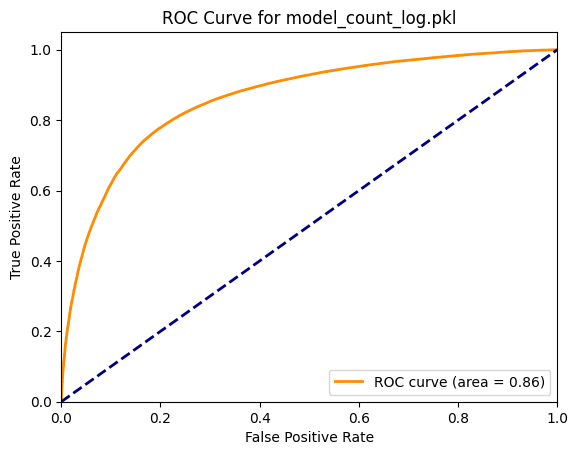

model_tfidf_log.pkl			=======================


{'Accuracy': 0.7900687489712976,
 'Precision': 0.7826938816001587,
 'Recall': 0.801437350805018,
 'F1 Score': 0.7919547296703848,
 'ROC AUC': 0.8683955828593536,
 'Prediction Time (s)': 0.933729887008667}

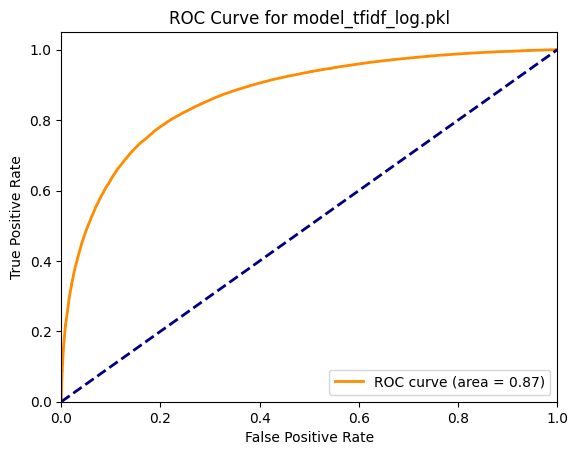

model_embedding_simple			=======================
 105/4937 [..............................] - ETA: 4s

2024-03-14 16:14:28.442561: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 323514368 exceeds 10% of free system memory.


4937/4937 [==============================] - 5s 1ms/step


{'Accuracy': 0.7784586556600788,
 'Precision': 0.7686772434795422,
 'Recall': 0.7948346792625324,
 'F1 Score': 0.7815371554135038,
 'ROC AUC': 0.8568171432714707,
 'Prediction Time (s)': 8.96670913696289}

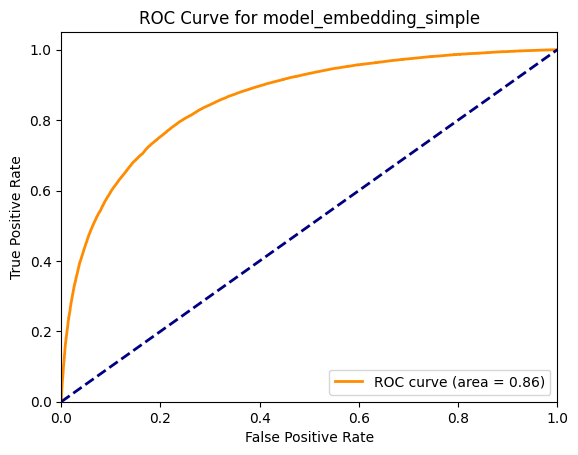

model_fastText			=======================
 141/4937 [..............................] - ETA: 3s

2024-03-14 16:14:36.811697: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 323514368 exceeds 10% of free system memory.


4937/4937 [==============================] - 3s 694us/step


{'Accuracy': 0.790967676588633,
 'Precision': 0.7835532189266938,
 'Recall': 0.8023769617552948,
 'F1 Score': 0.7928533788361647,
 'ROC AUC': 0.8708664067237848,
 'Prediction Time (s)': 6.342096567153931}

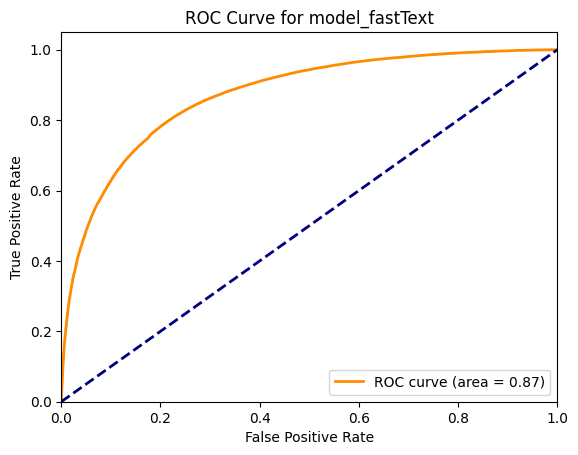

model_glove			=======================
  66/4937 [..............................] - ETA: 7s

2024-03-14 16:14:43.876487: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 323514368 exceeds 10% of free system memory.


4937/4937 [==============================] - 7s 1ms/step


{'Accuracy': 0.7570173328437765,
 'Precision': 0.7641278605728342,
 'Recall': 0.7415308040022347,
 'F1 Score': 0.7526597629895028,
 'ROC AUC': 0.838324221854355,
 'Prediction Time (s)': 10.356247186660767}

model_use			=======================
4937/4937 [==============================] - 17s 3ms/step


{'Accuracy': 0.779098033754099,
 'Precision': 0.7718915434111506,
 'Recall': 0.7905429427599167,
 'F1 Score': 0.7811059185145689,
 'ROC AUC': 0.8623082685763623,
 'Prediction Time (s)': 17.925758838653564}

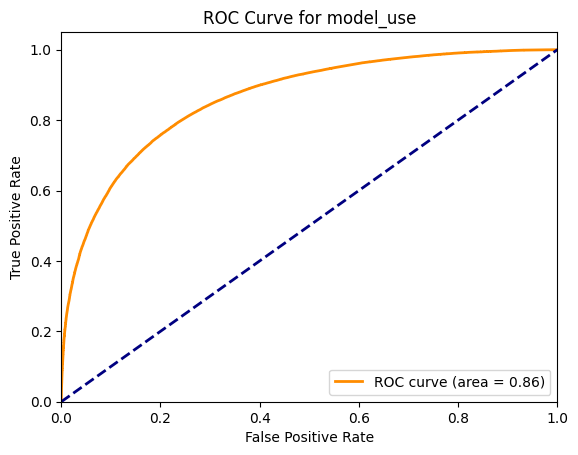

model_rnn			=======================
   4/4937 [..............................] - ETA: 1:43

2024-03-14 16:15:11.475550: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 323514368 exceeds 10% of free system memory.


4937/4937 [==============================] - 94s 19ms/step


{'Accuracy': 0.7947343099147918,
 'Precision': 0.8077285830045564,
 'Recall': 0.7720681598862309,
 'F1 Score': 0.7894958937903723,
 'ROC AUC': 0.8762684194790153,
 'Prediction Time (s)': 96.77137637138367}

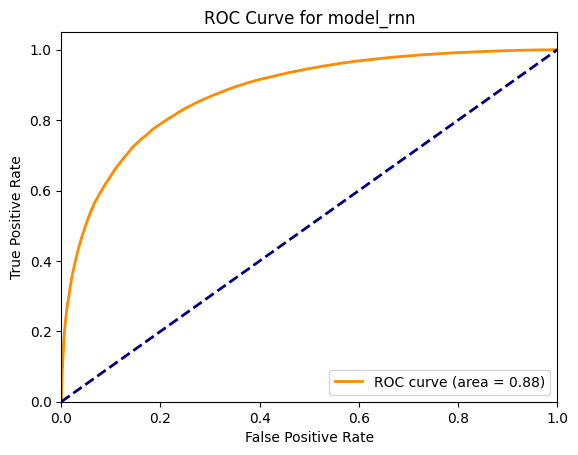

model_lstm			=======================


2024-03-14 16:16:48.463734: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 323514368 exceeds 10% of free system memory.


4937/4937 [==============================] - 272s 55ms/step


{'Accuracy': 0.7905625261132142,
 'Precision': 0.7877085118177695,
 'Recall': 0.7938696734217076,
 'F1 Score': 0.7907770919761206,
 'ROC AUC': 0.8704379997933912,
 'Prediction Time (s)': 274.5236415863037}

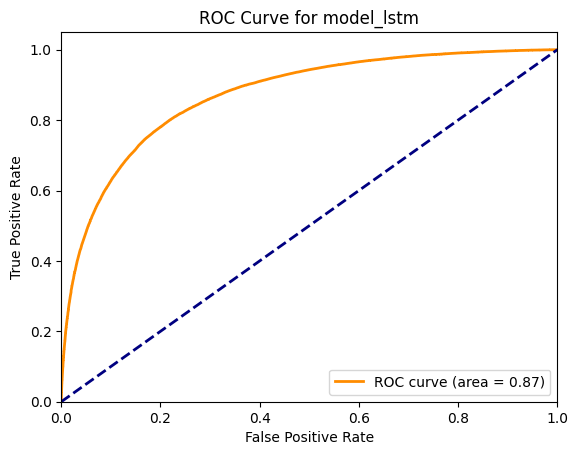

model_bilstm			=======================
4937/4937 [==============================] - 331s 67ms/step


{'Accuracy': 0.794993859438107,
 'Precision': 0.7971192782818186,
 'Recall': 0.7898318858245721,
 'F1 Score': 0.7934588499413235,
 'ROC AUC': 0.8740715130601521,
 'Prediction Time (s)': 334.0069377422333}

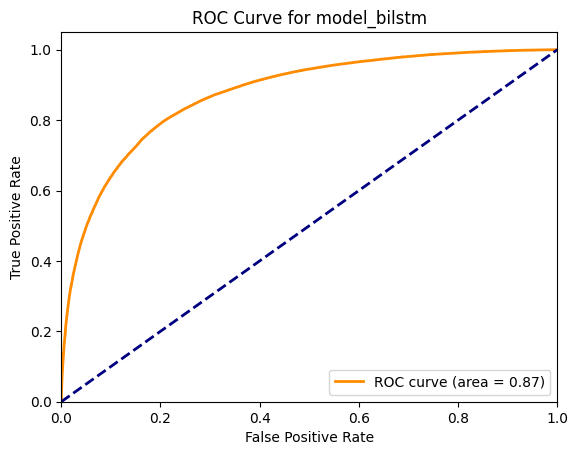

model_bilstm_stack			=======================
4937/4937 [==============================] - 528s 107ms/step


{'Accuracy': 0.7948039451527544,
 'Precision': 0.7893409255513099,
 'Recall': 0.8026309106607751,
 'F1 Score': 0.795930444855765,
 'ROC AUC': 0.8734184680287497,
 'Prediction Time (s)': 530.9576604366302}

model_bert			=======================


/home/nlombard/Projets/Formation/Ingenieur IA/Project 7/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


4937/4937 [==============================] - 24644s 5s/step


{'Accuracy': 0.7427041262043731,
 'Precision': 0.7498099158385989,
 'Recall': 0.7262557773375997,
 'F1 Score': 0.7378449154400857,
 'ROC AUC': 0.8218491420999394,
 'Prediction Time (s)': 24672.28439807892}

In [13]:
# Prédiction avec les différents modèles et affichage de la courbe ROC pour chaque modèle
for model_name, model in loaded_models.items():
    print(model_name + "\t\t\t=======================")
    start_time = time.time()
    
    if ".pkl" in model_name:
        # Pour les modèles scikit-learn
        y_pred = model.predict_proba(X_val)[:, 1]
    elif "model_bert" in model_name:
        # Pour les modèles BERT
        X_val_enc = [loaded_tokenizer[model_name].encode_plus(text, add_special_tokens=True, max_length=256, pad_to_max_length=True, return_attention_mask=True, truncation=True) for text in X_val]
        X_val_ids = np.array([x['input_ids'] for x in X_val_enc])
        X_val_masks = np.array([x['attention_mask'] for x in X_val_enc])
        y_pred = model.predict([X_val_ids, X_val_masks]).flatten()
    elif "model_use" in model_name:
        # Pour les modèles USE
        y_pred = model.predict(tf.convert_to_tensor(X_val)).flatten()
    else:
        # Pour les autres modèles TensorFlow/Keras nécessitant un tokenizer
        X_val_seq = loaded_tokenizer[model_name].texts_to_sequences(X_val)
        X_val_pad = pad_sequences(X_val_seq, maxlen=512)
        y_pred = model.predict(X_val_pad).flatten()

    accuracy = accuracy_score(y_val, (y_pred > 0.5).astype(int))
    precision = precision_score(y_val, (y_pred > 0.5).astype(int))
    recall = recall_score(y_val, (y_pred > 0.5).astype(int))
    f1 = f1_score(y_val, (y_pred > 0.5).astype(int))
    roc_auc = roc_auc_score(y_val, y_pred)

    end_time = time.time()

    metrics_dict = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Prediction Time (s)': end_time - start_time
    }
    display(metrics_dict)

    # Calcul de la courbe ROC et AUC
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)

    # Affichage de la courbe ROC pour le modèle courant
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()